In [1]:
!pip install yfinance
!pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.9 MB/s eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
from pyts.image import GramianAngularField
import yfinance as yf

In [3]:
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential, utils
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import load_model

In [4]:
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Step 1

## 1.a Collecting Data

In [17]:
def download_daily_return_data(start_dt, end_dt):
  df = pd.DataFrame()
  df_ret = pd.DataFrame()
  for tick in tickers:
      ydata = yf.download(tick, start=start_dt, end=end_dt)
      df[tick] = ydata['Adj Close']
      df_ret[tick] = df[tick].pct_change().dropna()
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.set_figheight(4)
      fig.set_figwidth(12)

      ax1.plot(df.index, df[tick])
      ax1.set_title("{} Price".format(tick))
      ax1.set_xlabel('time in years')
      ax1.set_ylabel('Price in $')

      ax2.plot(df_ret.index, df_ret[tick] * 100)
      ax2.set_title("{} Daily Returns".format(tick))
      ax2.set_xlabel('time in years')
      ax2.set_ylabel('Price change in %')
      plt.show()

  df.index = pd.to_datetime(df.index, format="%Y%m%d")
  df_ret.index = pd.to_datetime(df_ret.index, format="%Y%m%d")
  return df, df_ret

In [18]:
tickers = ["DBO"]

[*********************100%%**********************]  1 of 1 completed


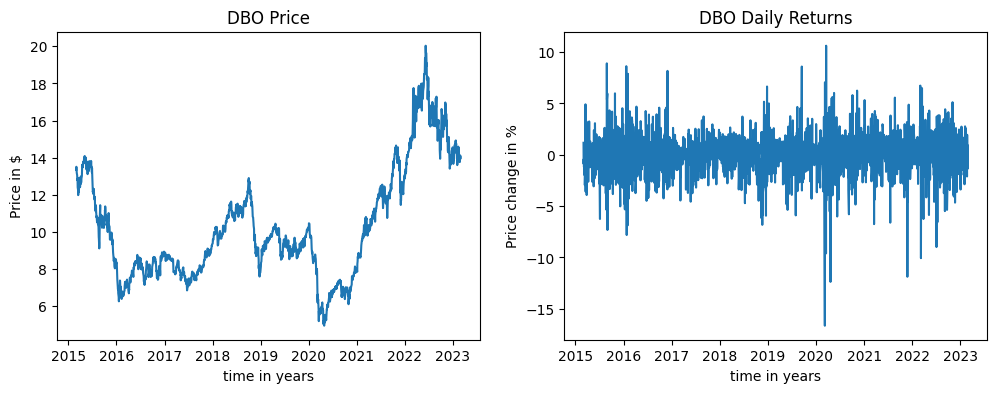

In [19]:
df_price, df_ret = download_daily_return_data("2015-03-01", "2023-3-1")

In [9]:
df_ret.shape

(2013, 1)

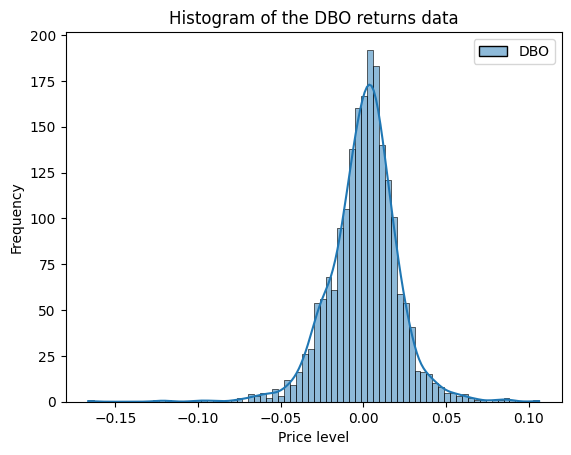

In [22]:
sns.histplot(df_ret, kde=True)
plt.title('Histogram of the DBO returns data')
plt.xlabel('Price level')
plt.ylabel('Frequency')
plt.show()

The distribution of DBO daily returns is centered on 0 but left-skewed.

## 1.b Problem Formulation

The task is to predict whether the 25-day future return is positive or not.

In [10]:
def create_dataset(ticker, df_ret, df_price):
  df = df_ret[[ticker]]
  df.columns = ['Ret']
  df["Ret_25"] = df["Ret"].rolling(25).apply(lambda x: np.prod(1 + x) - 1)
  df["Ret25"] = df["Ret_25"].shift(-25)
  del df["Ret_25"]
  df['Price'] = df_price[ticker]
  df = df.dropna()
  return df

In [11]:
dbo_data = create_dataset('DBO', df_ret, df_price)
dbo_data.shape

(1988, 3)

In [12]:
dbo_data.tail()

Ret     Ret25      Price
Date                                     
2023-01-17  0.003264 -0.064411  14.709514
2023-01-18 -0.013663 -0.032982  14.508537
2023-01-19  0.015831 -0.041558  14.738224
2023-01-20  0.009740 -0.063666  14.881779
2023-01-23  0.003215 -0.058333  14.929630

In [13]:
df_price[df_price.index>'2023-01-23'].shape

(25, 1)

In [14]:
dbo_data['label'] = dbo_data['Ret25'] >= 0
dbo_data['label'] = dbo_data['label'].astype('int')

In [15]:
dbo_data.label.value_counts()

1    1121
0     867
Name: label, dtype: int64

##1.c Training Models

In [65]:
def create_train_test(df, features, label, window_size, test_size, verbose=False, input_scale=True, leakage_band=0):
  '''
  leakage_band controls how many samples at the end of the
  training data will be discarded to prevent information leak
  '''
  split_index = int(df.shape[0] - test_size)
  X_train_set = df[features].iloc[:split_index - leakage_band]
  y_train_set = df[label].iloc[:split_index - leakage_band]
  X_test_set = df[features].iloc[split_index - window_size:]
  y_test_set = df[label].iloc[split_index - window_size:]

  if verbose:
    print("window size: ", window_size)
    print("Shape of dataset", X_train_set.shape, y_train_set.shape, X_test_set.shape, y_test_set.shape)
    print("Training: {}~{}, Test: {}~{}".format(y_train_set.index[window_size], y_train_set.index[-1], y_test_set.index[window_size], y_test_set.index[-1]))

  if input_scale:
    scaler_input = MinMaxScaler(feature_range=(-1, 1))
    scaler_input.fit(X_train_set)
    X_train_set_scaled = scaler_input.transform(X_train_set)
    X_test_set_scaled = scaler_input.transform(X_test_set)
  else:
    X_train_set_scaled = X_train_set.values
    X_test_set_scaled = X_test_set.values


  y_train_set = y_train_set.values.reshape(len(y_train_set), -1)
  y_test_set = y_test_set.values.reshape(len(y_test_set), -1)


  X_train = []
  y_train = []

  for i in range(window_size, y_train_set.shape[0]):
      X_train.append(X_train_set_scaled[i - window_size : i, :])
      y_train.append(y_train_set[i])

  X_train, y_train = np.array(X_train), np.array(y_train)

  if verbose:
    print("Shape of training data", X_train.shape, y_train.shape)

  X_test = []
  y_test = []

  for i in range(window_size, y_test_set.shape[0]):
      X_test.append(X_test_set_scaled[i - window_size : i, :])
      y_test.append(y_test_set[i])

  X_test, y_test = np.array(X_test), np.array(y_test)
  if verbose:
    print("Shape of test data", X_test.shape, y_test.shape)
  return X_train, y_train, X_test, y_test

In [181]:
def train_model(model, X_train, y_train, epochs=100, batch_size=64, lr=1e-3, loss="binary_crossentropy", metrics=["accuracy"],
                validation_split=0.15, monitor='val_loss', mode='min', patience=20, verbose=1, warming_up=10):
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=metrics)
  es = tf.keras.callbacks.EarlyStopping(
      monitor=monitor,
      mode=mode,
      verbose=verbose,
      patience=patience,
      restore_best_weights=True
  )
  class_weight = {0: (np.mean(y_train) / 0.5), 1: 1}
  if warming_up > 0:
    model.fit(X_train, y_train, epochs=warming_up, verbose=verbose, class_weight=class_weight)
    model.compile(optimizer='Adam', loss=loss, metrics=metrics)
  history = model.fit(
      X_train,
      y_train,
      validation_split=validation_split,
      epochs=epochs,
      batch_size=batch_size,
      verbose=verbose,
      callbacks=[es],
      class_weight=class_weight
  )
  best_epoch = np.argmin(history.history[monitor]) if mode == 'min' else np.argmax(history.history[monitor])
  print("Best Eopch: {}".format(best_epoch + warming_up))

In [58]:
def eval_classification(X_test, y_test, model):
  acc = model.evaluate(x=X_test, y=y_test)
  print("Accuracy over test: {:.2f}%".format(acc[1] * 100))

  y_prob = model.predict(X_test)
  y_pred = np.round(y_prob)
  eval_confusion_matrix(y_test, y_pred)

In [59]:
def eval_confusion_matrix(label, prediction, thres=0.5):
  pred = [1 if ele > thres else 0 for ele in prediction]
  cm = metrics.confusion_matrix(label, pred)
  cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
  cm.plot(values_format="", cmap="Blues")
  print(classification_report(label, pred))

### MLP

In [44]:
def create_MLP(window_size, SEED=42):
  K.clear_session()
  tf.random.set_seed(SEED)

  model = Sequential()
  model.add(Dense(units=50, activation="relu", input_dim=window_size))
  model.add(Dense(units=50, activation="relu"))
  model.add(Dense(units=30, activation="relu"))
  model.add(Dense(units=10, activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))
  return model

In [78]:
X_train, y_train, X_test, y_test = create_train_test(dbo_data, ['Ret'], 'label', window_size=30, test_size=400, verbose=True)

window size:  30
Shape of dataset (1588, 1) (1588,) (430, 1) (430,)
Training: 2015-04-15 00:00:00~2021-06-21 00:00:00, Test: 2021-06-22 00:00:00~2023-01-23 00:00:00
Shape of training data (1558, 30, 1) (1558, 1)
Shape of test data (400, 30, 1) (400, 1)


In [104]:
model_mlp = create_MLP(30)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                1550      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 10)                310       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5951 (23.25 KB)
Trainable params: 5951 (23.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
train_model(model_mlp, X_train, y_train, warming_up=0)

Epoch 1/100
21/21 [==============================] - 1s 16ms/step - loss: 0.7330 - accuracy: 0.4887 - val_loss: 0.6942 - val_accuracy: 0.4274
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 0.7316 - accuracy: 0.5340 - val_loss: 0.6892 - val_accuracy: 0.5171
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.7296 - accuracy: 0.5347 - val_loss: 0.6890 - val_accuracy: 0.5470
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.7281 - accuracy: 0.5408 - val_loss: 0.6859 - val_accuracy: 0.5769
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.7255 - accuracy: 0.5680 - val_loss: 0.6917 - val_accuracy: 0.5085
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.7244 - accuracy: 0.5574 - val_loss: 0.6712 - val_accuracy: 0.6410
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.7215 - accuracy: 0.5498 - val_loss: 0.6514 - val_accuracy: 0.7009
Epoch 8/100


In [142]:
# model_mlp.save('model_mlp_es.h5')

49/49 [==============================] - 0s 1ms/step - loss: 0.5702 - accuracy: 0.6881
Accuracy over test: 68.81%
49/49 [==============================] - 0s 984us/step
              precision    recall  f1-score   support

           0       0.71      0.48      0.58       685
           1       0.68      0.85      0.75       873

    accuracy                           0.69      1558
   macro avg       0.70      0.67      0.66      1558
weighted avg       0.69      0.69      0.68      1558



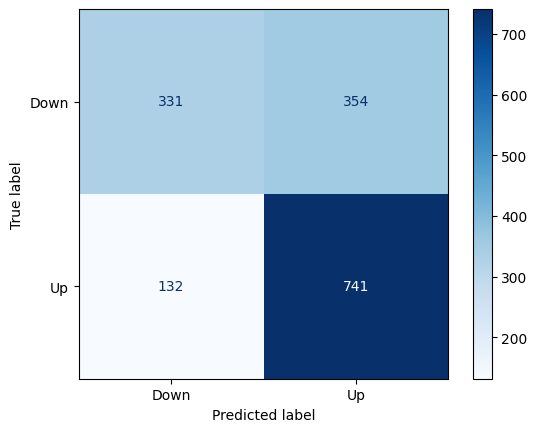

In [106]:
eval_classification(X_train, y_train, model_mlp)

13/13 [==============================] - 0s 1ms/step - loss: 0.7484 - accuracy: 0.5475
Accuracy over test: 54.75%
13/13 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.47      0.18      0.26       177
           1       0.56      0.84      0.67       223

    accuracy                           0.55       400
   macro avg       0.52      0.51      0.47       400
weighted avg       0.52      0.55      0.49       400



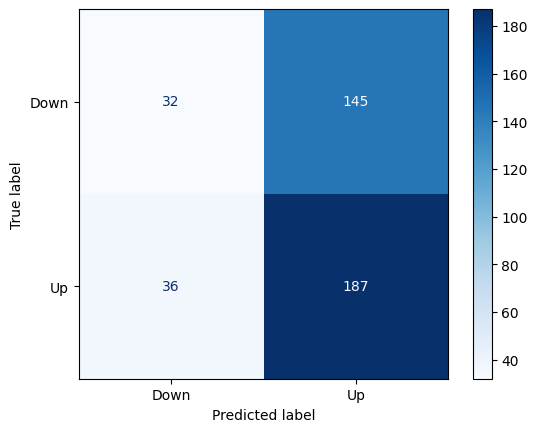

In [107]:
eval_classification(X_test, y_test, model_mlp)

### LSTM

In [45]:
def create_LSTM(window_size, n_features, SEED=42):
  K.clear_session()
  tf.random.set_seed(SEED)

  units_lstm = 50
  model = Sequential()
  model.add(
      LSTM(
          units=units_lstm,
          return_sequences=True,
          activation="tanh",
          input_shape=(window_size, n_features),
      )
  )
  model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))

  model.add(Dense(units=30, activation="relu"))

  model.add(Dense(units=10, activation="relu"))

  model.add(Dense(units=1, activation="sigmoid"))
  return model

In [131]:
X_train, y_train, X_test, y_test = create_train_test(dbo_data, ['Ret'], 'label', window_size=30, test_size=400, verbose=True)

window size:  30
Shape of dataset (1588, 1) (1588,) (430, 1) (430,)
Training: 2015-04-15 00:00:00~2021-06-21 00:00:00, Test: 2021-06-22 00:00:00~2023-01-23 00:00:00
Shape of training data (1558, 30, 1) (1558, 1)
Shape of test data (400, 30, 1) (400, 1)


In [136]:
model_lstm = create_LSTM(30, 1)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 30)                1530      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 32451 (126.76 KB)
Trainable params: 32451 (126.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [137]:
train_model(model_lstm, X_train, y_train, warming_up=0)

Epoch 1/100
21/21 [==============================] - 6s 86ms/step - loss: 0.7340 - accuracy: 0.5249 - val_loss: 0.6891 - val_accuracy: 0.7650
Epoch 2/100
21/21 [==============================] - 1s 58ms/step - loss: 0.7333 - accuracy: 0.5385 - val_loss: 0.6915 - val_accuracy: 0.6709
Epoch 3/100
21/21 [==============================] - 1s 60ms/step - loss: 0.7332 - accuracy: 0.4894 - val_loss: 0.6882 - val_accuracy: 0.7521
Epoch 4/100
21/21 [==============================] - 1s 36ms/step - loss: 0.7333 - accuracy: 0.5121 - val_loss: 0.6914 - val_accuracy: 0.7137
Epoch 5/100
21/21 [==============================] - 1s 36ms/step - loss: 0.7329 - accuracy: 0.5393 - val_loss: 0.6904 - val_accuracy: 0.7308
Epoch 6/100
21/21 [==============================] - 1s 37ms/step - loss: 0.7341 - accuracy: 0.5076 - val_loss: 0.6808 - val_accuracy: 0.7650
Epoch 7/100
21/21 [==============================] - 1s 37ms/step - loss: 0.7328 - accuracy: 0.4856 - val_loss: 0.6938 - val_accuracy: 0.6111
Epoch 

In [141]:
# model_lstm.save('model_lstm_es.h5')

49/49 [==============================] - 1s 11ms/step - loss: 0.6654 - accuracy: 0.5494
Accuracy over test: 54.94%
49/49 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.49      0.53      0.51       684
           1       0.61      0.56      0.58       874

    accuracy                           0.55      1558
   macro avg       0.55      0.55      0.55      1558
weighted avg       0.55      0.55      0.55      1558



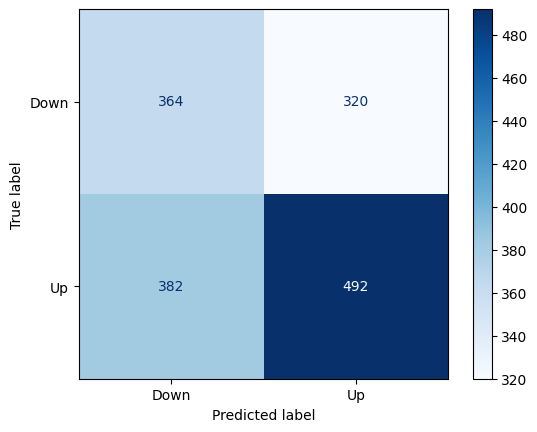

In [138]:
eval_classification(X_train, y_train, model_lstm)

13/13 [==============================] - 0s 11ms/step - loss: 0.7325 - accuracy: 0.4525
Accuracy over test: 45.25%
13/13 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.37      0.35      0.36       177
           1       0.51      0.53      0.52       223

    accuracy                           0.45       400
   macro avg       0.44      0.44      0.44       400
weighted avg       0.45      0.45      0.45       400



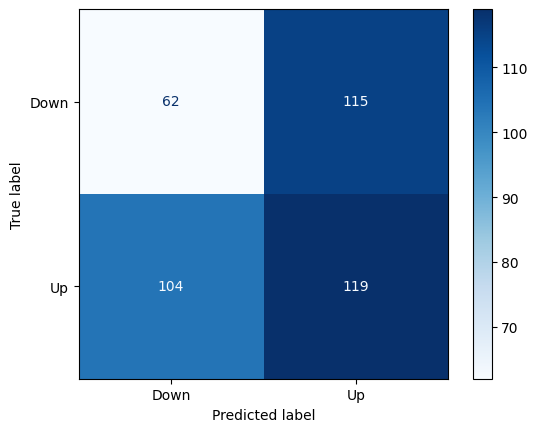

In [139]:
eval_classification(X_test, y_test, model_lstm)

### CNN on GAF

In [122]:
X_train, y_train, X_test, y_test = create_train_test(dbo_data, ['Price'], 'label', window_size=30, test_size=400, verbose=True, input_scale=False)

window size:  30
Shape of dataset (1588, 1) (1588,) (430, 1) (430,)
Training: 2015-04-15 00:00:00~2021-06-21 00:00:00, Test: 2021-06-22 00:00:00~2023-01-23 00:00:00
Shape of training data (1558, 30, 1) (1558, 1)
Shape of test data (400, 30, 1) (400, 1)


In [123]:
transformer = GramianAngularField()
X_train_gaf = transformer.transform(X_train.reshape((-1, 30)))
X_train_gaf = X_train_gaf * 255.0
print(X_train_gaf.shape)

(1558, 30, 30)


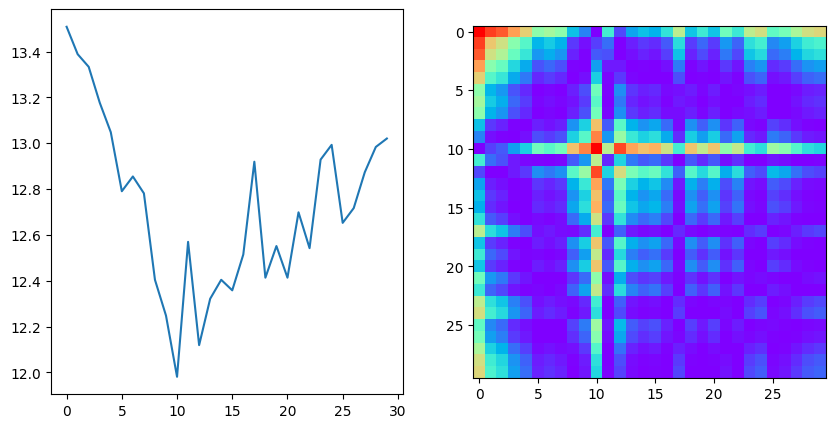

In [124]:
# Show the results for the first time series
fig, ax = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={"width_ratios": [1, 1]})
ax[0].plot(X_train[0, :])
ax[1].imshow(X_train_gaf[0], cmap="rainbow")

In [125]:
X_test_gaf = transformer.transform(X_test.reshape((-1, 30)))
X_test_gaf = X_test_gaf * 255.0
print(X_test_gaf.shape)

(400, 30, 30)


In [46]:
def create_CNN(window_size, SEED=42):
    K.clear_session()
    tf.random.set_seed(SEED)
    model = tf.keras.Sequential()
    # Input layer
    model.add(tf.keras.layers.InputLayer(input_shape=(window_size, window_size, 1)))
    model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Flatten())
    # model.add(tf.keras.layers.Dense(1024, activation="relu"))
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.5, seed=SEED))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    return model

In [149]:
model_cnn = create_CNN(30)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 64)          0

In [150]:
train_model(model_cnn, X_train_gaf, y_train, warming_up=0)

Epoch 1/100
21/21 [==============================] - 2s 43ms/step - loss: 5.0823 - accuracy: 0.5045 - val_loss: 0.9154 - val_accuracy: 0.4487
Epoch 2/100
21/21 [==============================] - 1s 35ms/step - loss: 0.8323 - accuracy: 0.5211 - val_loss: 0.7337 - val_accuracy: 0.4231
Epoch 3/100
21/21 [==============================] - 1s 35ms/step - loss: 0.7249 - accuracy: 0.5438 - val_loss: 0.7019 - val_accuracy: 0.5043
Epoch 4/100
21/21 [==============================] - 1s 33ms/step - loss: 0.7156 - accuracy: 0.5566 - val_loss: 0.6818 - val_accuracy: 0.5983
Epoch 5/100
21/21 [==============================] - 1s 33ms/step - loss: 0.7102 - accuracy: 0.5657 - val_loss: 0.7383 - val_accuracy: 0.4274
Epoch 6/100
21/21 [==============================] - 1s 34ms/step - loss: 0.7051 - accuracy: 0.5718 - val_loss: 0.6920 - val_accuracy: 0.6068
Epoch 7/100
21/21 [==============================] - 1s 33ms/step - loss: 0.6991 - accuracy: 0.5687 - val_loss: 0.6997 - val_accuracy: 0.5641
Epoch 

In [154]:
# model_cnn.save('model_cnn_es.h5')

49/49 [==============================] - 0s 6ms/step - loss: 0.5212 - accuracy: 0.7587
Accuracy over test: 75.87%
49/49 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       684
           1       0.74      0.87      0.80       874

    accuracy                           0.76      1558
   macro avg       0.77      0.74      0.75      1558
weighted avg       0.76      0.76      0.75      1558



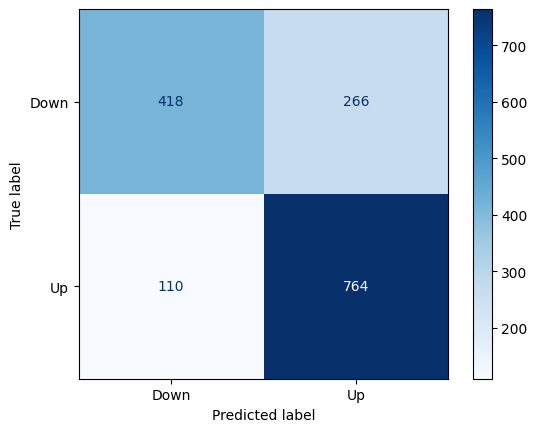

In [151]:
eval_classification(X_train_gaf, y_train, model_cnn)

13/13 [==============================] - 0s 8ms/step - loss: 0.7391 - accuracy: 0.5375
Accuracy over test: 53.75%
13/13 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0       0.46      0.27      0.34       177
           1       0.56      0.75      0.64       223

    accuracy                           0.54       400
   macro avg       0.51      0.51      0.49       400
weighted avg       0.52      0.54      0.51       400



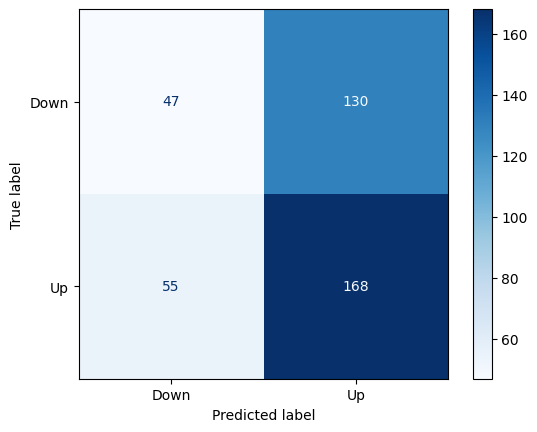

In [152]:
eval_classification(X_test_gaf, y_test, model_cnn)

## 1.d Backtest

In [194]:
def backtest(df_res, dates=[]):
  df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
  df_res["Positions_shift"] = df_res["Positions"].shift(1)
  df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
  df_res["Positions_L"] = df_res["Positions"].shift(1)
  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
  df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
  df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
  df_res["CumRet_L"] = (
      df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
  )
  df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

  Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
  Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
  Buy_Return = np.prod(1 + df_res["Ret"]) - 1

  print("Strat Return Long Only =", Final_Return_L * 100, "%")
  print("Strat Return =", Final_Return * 100, "%")
  print("Buy and Hold Return =", Buy_Return * 100, "%")

  fig = plt.figure(figsize=(12, 6))
  ax = plt.gca()
  df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
  df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
  df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
  for d in dates:
    dt = pd.to_datetime(d)
    plt.plot([dt, dt], [-0.2, 1], "r--")
  plt.xlabel("date")
  plt.ylabel("Cumulative Returns")
  plt.grid()
  plt.show()

Strat Return Long Only = 170.22262200155174 %
Strat Return = 430.9684082025165 %
Buy and Hold Return = 23.502762369918507 %


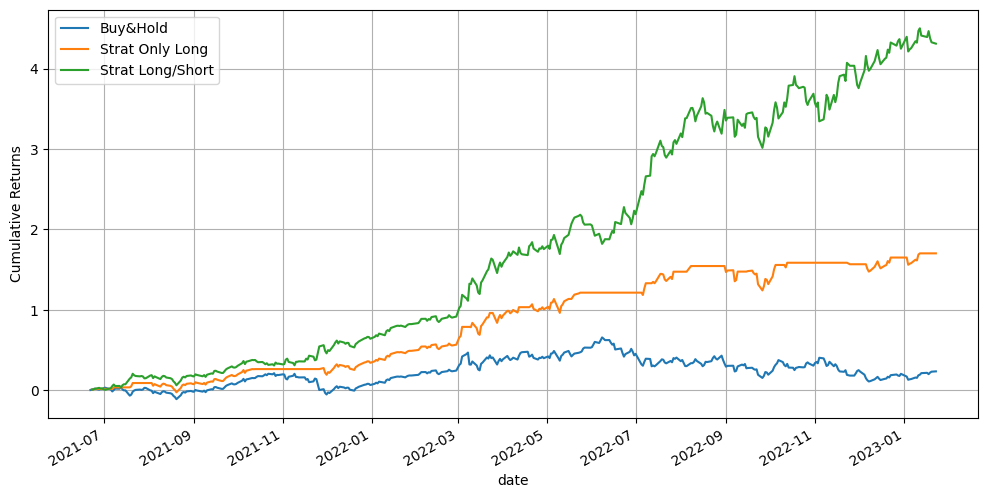

In [264]:
df_res = dbo_data[['Ret']].iloc[-400:]
df_res['Pred'] = dbo_data[['label']].iloc[-400:]
df_res.reset_index(inplace=True)
backtest(df_res)

### MLP

In [28]:
X_train, y_train, X_test, y_test = create_train_test(dbo_data, ['Ret'], 'label', window_size=30, test_size=400, verbose=True)

window size:  30
Shape of dataset (1588, 1) (1588,) (430, 1) (430,)
Training: 2015-04-15 00:00:00~2021-06-21 00:00:00, Test: 2021-06-22 00:00:00~2023-01-23 00:00:00
Shape of training data (1558, 30, 1) (1558, 1)
Shape of test data (400, 30, 1) (400, 1)


In [109]:
model_mlp = load_model('model_mlp_es.h5')

In [110]:
df_res = dbo_data[['Ret']].iloc[-400:]
df_res['Pred'] = model_mlp.predict(X_test, verbose=0)
df_res.reset_index(inplace=True)
df_res.head()

Date       Ret      Pred
0 2021-06-22  0.003145  0.508713
1 2021-06-23  0.007053  0.450552
2 2021-06-24  0.003891  0.586326
3 2021-06-25  0.006202  0.559187
4 2021-06-28 -0.012327  0.477949

Strat Return Long Only = 54.15602496599414 %
Strat Return = 79.58534955646648 %
Buy and Hold Return = 23.502762369918507 %


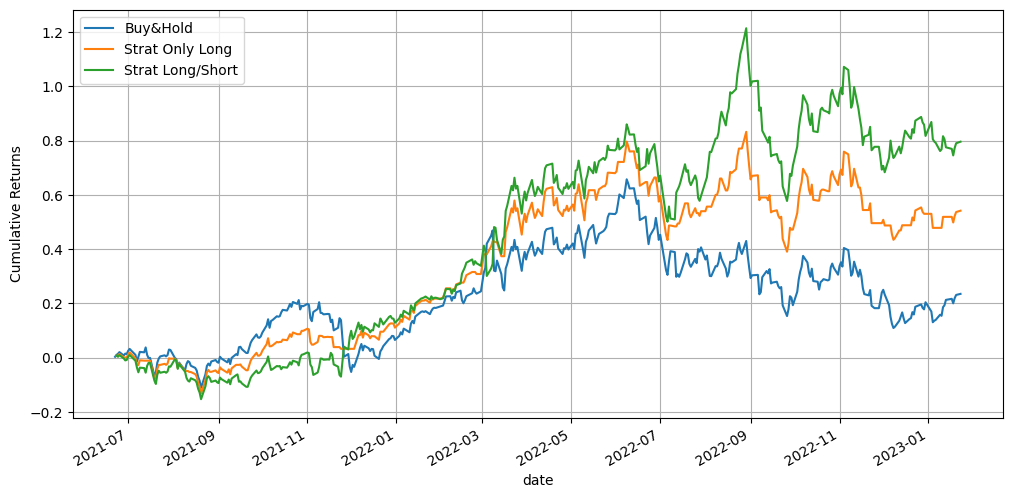

In [111]:
backtest(df_res)

### LSTM

In [34]:
X_train, y_train, X_test, y_test = create_train_test(dbo_data, ['Ret'], 'label', window_size=30, test_size=400, verbose=True)

window size:  30
Shape of dataset (1588, 1) (1588,) (430, 1) (430,)
Training: 2015-04-15 00:00:00~2021-06-21 00:00:00, Test: 2021-06-22 00:00:00~2023-01-23 00:00:00
Shape of training data (1558, 30, 1) (1558, 1)
Shape of test data (400, 30, 1) (400, 1)


In [35]:
model_lstm = load_model('model_lstm_es.h5')

In [36]:
df_res = dbo_data[['Ret']].iloc[-400:]
df_res['Pred'] = model_lstm.predict(X_test, verbose=0)
df_res.reset_index(inplace=True)
df_res.head()

Date       Ret      Pred
0 2021-06-22  0.003145  0.526169
1 2021-06-23  0.007053  0.547710
2 2021-06-24  0.003891  0.591446
3 2021-06-25  0.006202  0.653332
4 2021-06-28 -0.012327  0.608760

Strat Return Long Only = 14.004872094482511 %
Strat Return = -0.30069829232378664 %
Buy and Hold Return = 23.502762369918507 %


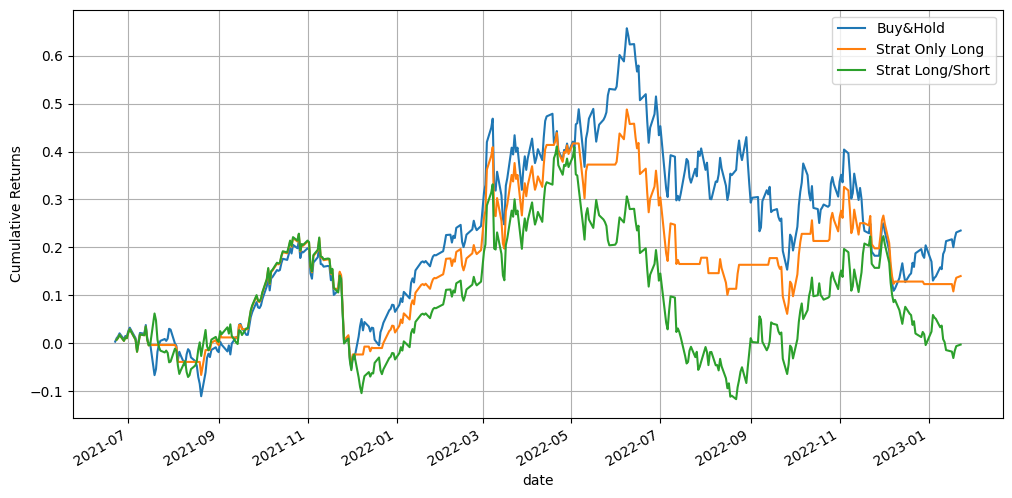

In [37]:
backtest(df_res)

### CNN on GAF

In [38]:
X_train, y_train, X_test, y_test = create_train_test(dbo_data, ['Price'], 'label', window_size=30, test_size=400, verbose=True, input_scale=False)

transformer = GramianAngularField()
X_train_gaf = transformer.transform(X_train.reshape((-1, 30)))
X_train_gaf = X_train_gaf * 255.0
X_test_gaf = transformer.transform(X_test.reshape((-1, 30)))
X_test_gaf = X_test_gaf * 255.0

window size:  30
Shape of dataset (1588, 1) (1588,) (430, 1) (430,)
Training: 2015-04-15 00:00:00~2021-06-21 00:00:00, Test: 2021-06-22 00:00:00~2023-01-23 00:00:00
Shape of training data (1558, 30, 1) (1558, 1)
Shape of test data (400, 30, 1) (400, 1)


In [39]:
model_cnn = load_model('model_cnn_es.h5')

In [41]:
df_res = dbo_data[['Ret']].iloc[-400:]
df_res['Pred'] = model_cnn.predict(X_test_gaf, verbose=0)
df_res.reset_index(inplace=True)
df_res.head()

Date       Ret      Pred
0 2021-06-22  0.003145  0.509395
1 2021-06-23  0.007053  0.211196
2 2021-06-24  0.003891  0.539245
3 2021-06-25  0.006202  0.409605
4 2021-06-28 -0.012327  0.449204

Strat Return Long Only = 26.783804030805534 %
Strat Return = 25.361335945855636 %
Buy and Hold Return = 23.502762369918507 %


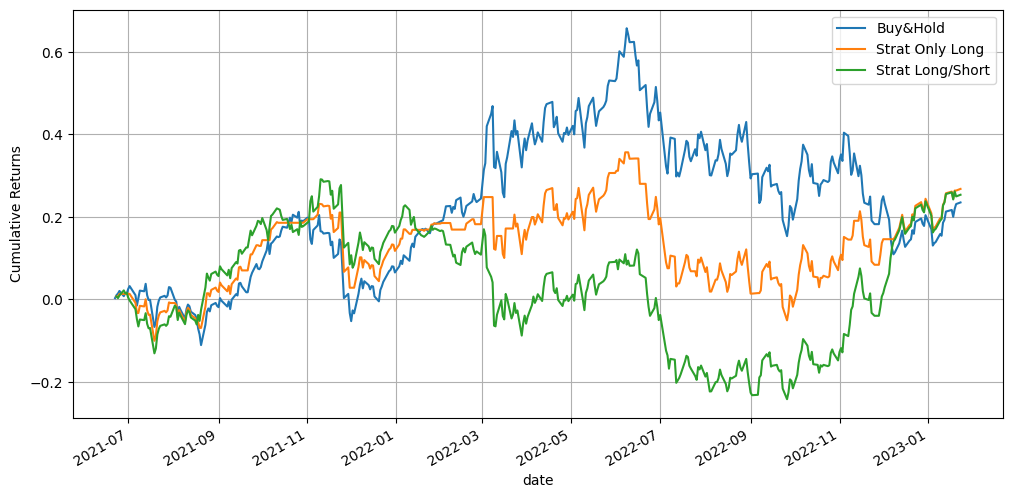

In [42]:
backtest(df_res)

# Step 2

## non-anchored walk forward method with a train/test split 500/500

In [49]:
import pickle

def save_to_pickle(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

### MLP

In [185]:
n_train = 500
n_test = 500
padding = 0
window_size = 30

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Ret'], 'label', window_size=window_size, test_size=test_size, verbose=True, leakage_band=padding)

    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_MLP(window_size)
    train_model(model, X_train, y_train, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))


df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (530, 1) (530,) (530, 1) (530,)
Training: 2015-04-15 00:00:00~2017-04-06 00:00:00, Test: 2017-04-07 00:00:00~2019-04-03 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 16
window size:  30
Shape of dataset (530, 1) (530,) (530, 1) (530,)
Training: 2017-04-07 00:00:00~2019-04-03 00:00:00, Test: 2019-04-04 00:00:00~2021-03-29 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 43
window size:  30
Shape of dataset (530, 1) (530,) (488, 1) (488,)
Training: 2019-04-04 00:00:00~2021-03-29 00:00:00, Test: 2021-03-30 00:00:00~2023-01-23 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (458, 30, 1) (458, 1)
Best Eopch: 12


In [189]:
save_to_pickle(df_predictions, 'df_predictions_mlp_500_leaky.pkl')

Strat Return Long Only = 133.403806725102 %
Strat Return = 144.12204869908604 %
Buy and Hold Return = 81.279545776673 %


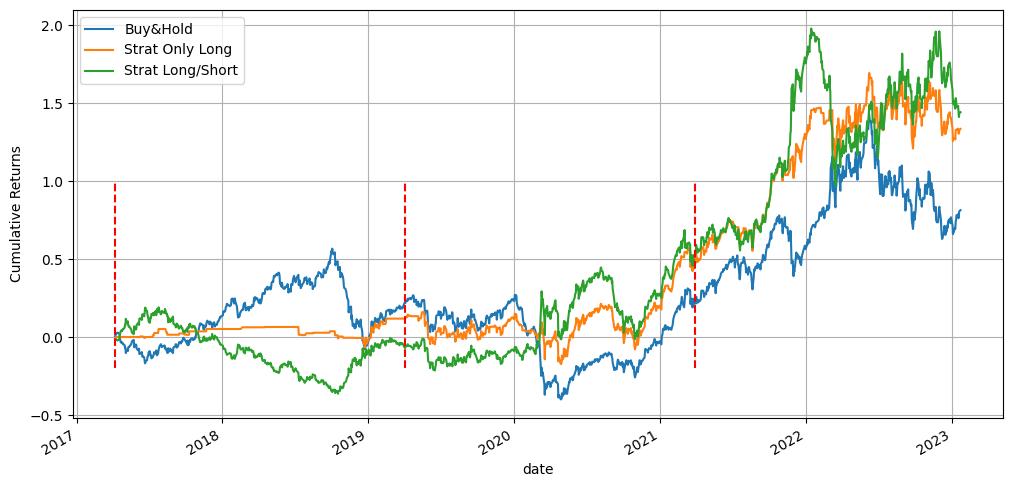

In [196]:
backtest(df_predictions, ['2017-04-07', '2019-04-04', '2021-03-30'])

              precision    recall  f1-score   support

         0.0       0.39      0.42      0.41       573
         1.0       0.61      0.58      0.60       885

    accuracy                           0.52      1458
   macro avg       0.50      0.50      0.50      1458
weighted avg       0.52      0.52      0.52      1458



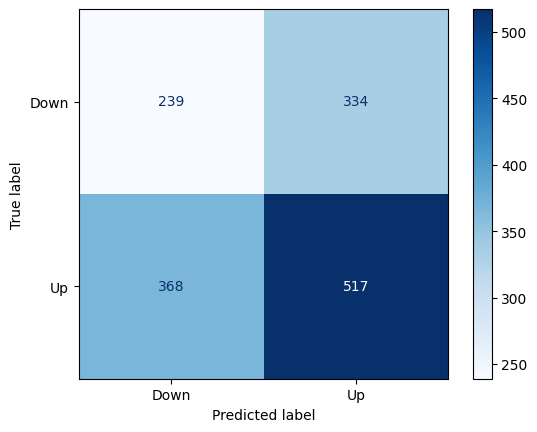

In [171]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = 34.171042163671814 %
Strat Return = 39.89174729890721 %
Buy and Hold Return = 23.11560369565777 %


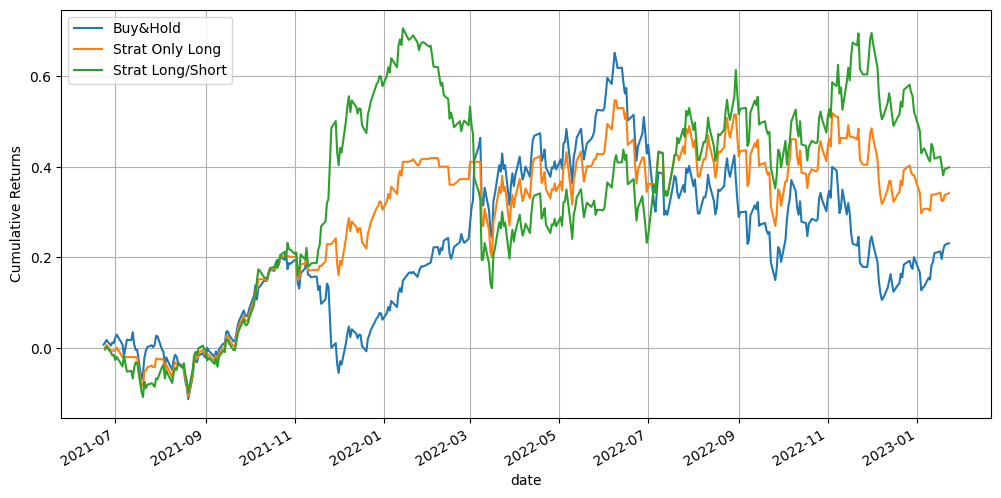

In [188]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.36      0.14      0.20       177
         1.0       0.54      0.81      0.65       222

    accuracy                           0.51       399
   macro avg       0.45      0.47      0.42       399
weighted avg       0.46      0.51      0.45       399



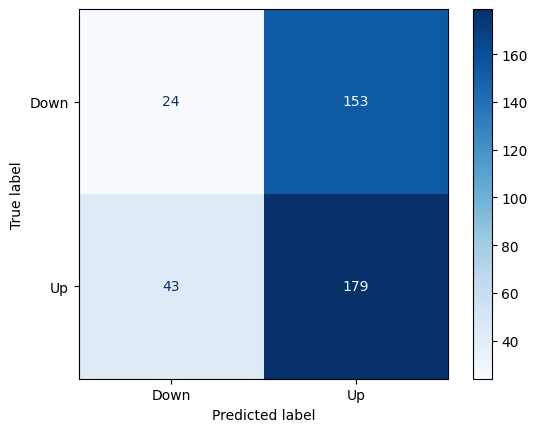

In [173]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

### LSTM

In [197]:
n_train = 500
n_test = 500
padding = 0
window_size = 30

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Ret'], 'label', window_size=window_size, test_size=test_size, verbose=True, leakage_band=padding)

    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_LSTM(window_size, 1)
    train_model(model, X_train, y_train, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (530, 1) (530,) (530, 1) (530,)
Training: 2015-04-15 00:00:00~2017-04-06 00:00:00, Test: 2017-04-07 00:00:00~2019-04-03 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 11
window size:  30
Shape of dataset (530, 1) (530,) (530, 1) (530,)
Training: 2017-04-07 00:00:00~2019-04-03 00:00:00, Test: 2019-04-04 00:00:00~2021-03-29 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 13
window size:  30
Shape of dataset (530, 1) (530,) (488, 1) (488,)
Training: 2019-04-04 00:00:00~2021-03-29 00:00:00, Test: 2021-03-30 00:00:00~2023-01-23 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (458, 30, 1) (458, 1)
Best Eopch: 20


In [198]:
save_to_pickle(df_predictions, 'df_predictions_lstm_500_leaky.pkl')

Strat Return Long Only = 3.013209336235012 %
Strat Return = -53.37911191972382 %
Buy and Hold Return = 81.279545776673 %


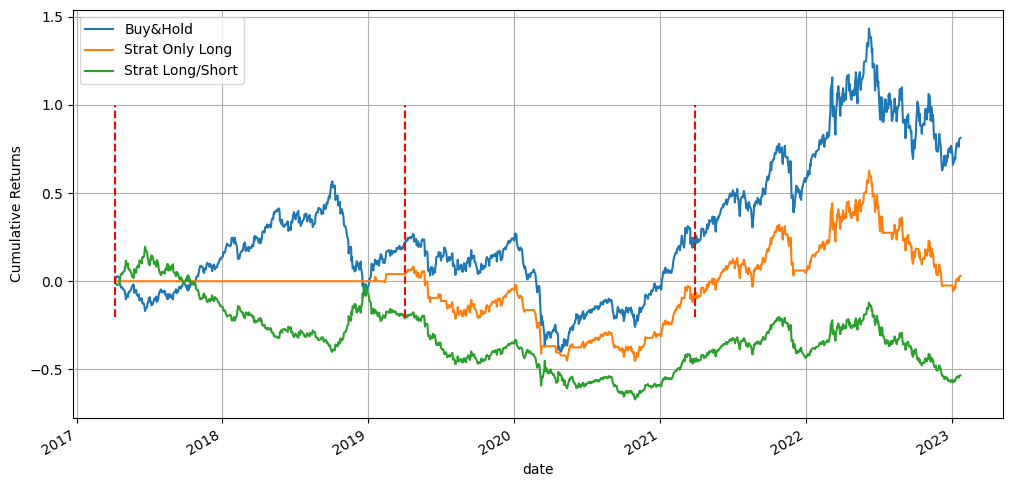

In [199]:
backtest(df_predictions, ['2017-04-07', '2019-04-04', '2021-03-30'])

              precision    recall  f1-score   support

         0.0       0.36      0.41      0.38       573
         1.0       0.58      0.53      0.55       885

    accuracy                           0.48      1458
   macro avg       0.47      0.47      0.47      1458
weighted avg       0.49      0.48      0.49      1458



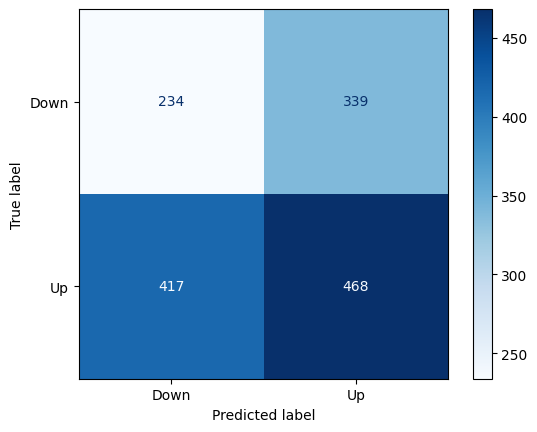

In [200]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = -6.4396296742577075 %
Strat Return = -29.844703331958613 %
Buy and Hold Return = 23.11560369565777 %


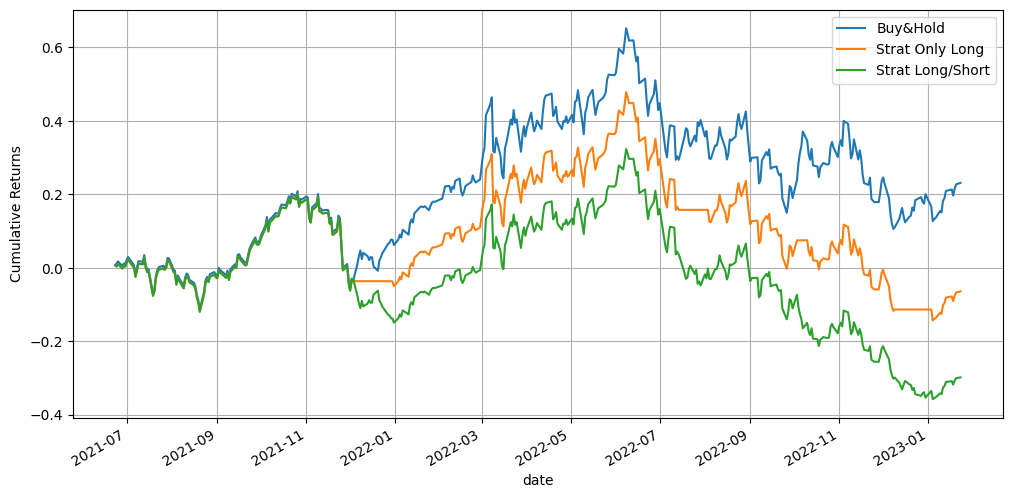

In [201]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.27      0.08      0.12       177
         1.0       0.53      0.83      0.65       222

    accuracy                           0.50       399
   macro avg       0.40      0.45      0.38       399
weighted avg       0.41      0.50      0.41       399



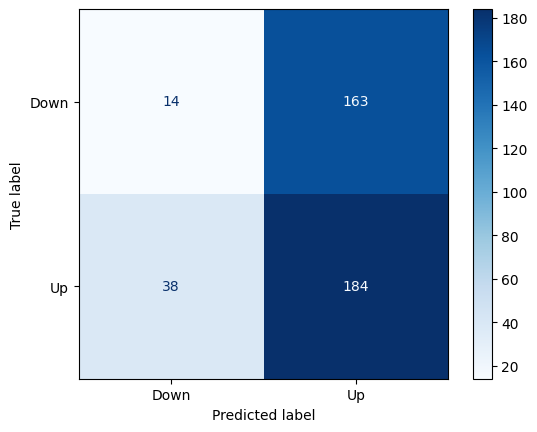

In [202]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

### CNN on GAF

In [203]:
n_train = 500
n_test = 500
padding = 0
window_size = 30

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Price'], 'label', window_size=window_size, test_size=test_size, verbose=True, input_scale=False, leakage_band=padding)

    transformer = GramianAngularField()
    X_train_gaf = transformer.transform(X_train.reshape((-1, 30)))
    X_train_gaf = X_train_gaf * 255.0
    X_test_gaf = transformer.transform(X_test.reshape((-1, 30)))
    X_test_gaf = X_test_gaf * 255.0


    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_CNN(window_size, 1)
    train_model(model, X_train_gaf, y_train, verbose=0)

    y_pred = model.predict(X_test_gaf, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (530, 1) (530,) (530, 1) (530,)
Training: 2015-04-15 00:00:00~2017-04-06 00:00:00, Test: 2017-04-07 00:00:00~2019-04-03 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 24
window size:  30
Shape of dataset (530, 1) (530,) (530, 1) (530,)
Training: 2017-04-07 00:00:00~2019-04-03 00:00:00, Test: 2019-04-04 00:00:00~2021-03-29 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 30
window size:  30
Shape of dataset (530, 1) (530,) (488, 1) (488,)
Training: 2019-04-04 00:00:00~2021-03-29 00:00:00, Test: 2021-03-30 00:00:00~2023-01-23 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (458, 30, 1) (458, 1)
Best Eopch: 16


In [204]:
save_to_pickle(df_predictions, 'df_predictions_cnn_500_leaky.pkl')

Strat Return Long Only = 14.30702659605707 %
Strat Return = -42.43066437375338 %
Buy and Hold Return = 81.279545776673 %


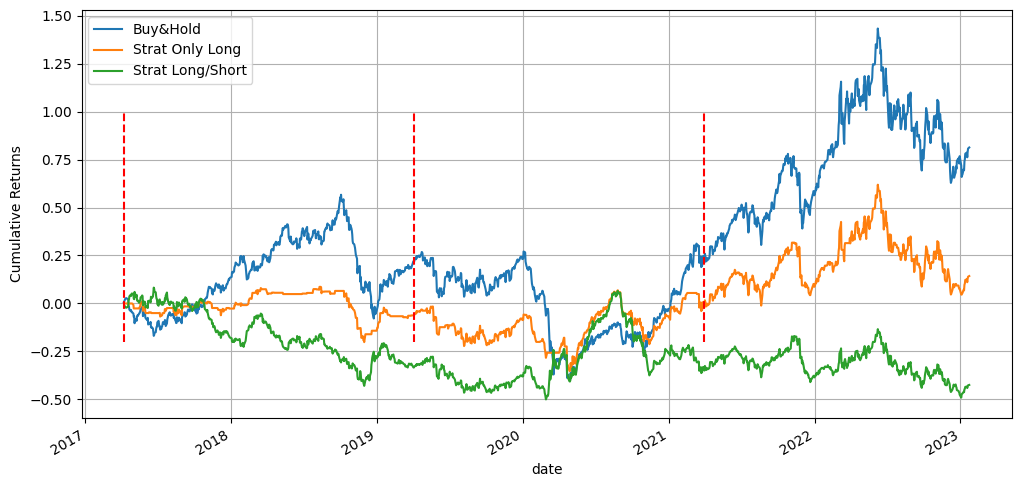

In [205]:
backtest(df_predictions, ['2017-04-07', '2019-04-04', '2021-03-30'])

              precision    recall  f1-score   support

         0.0       0.38      0.34      0.36       573
         1.0       0.60      0.64      0.62       885

    accuracy                           0.52      1458
   macro avg       0.49      0.49      0.49      1458
weighted avg       0.51      0.52      0.52      1458



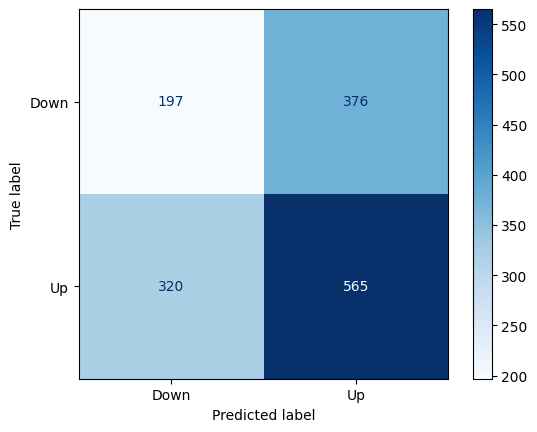

In [206]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = -1.5939367825589468 %
Strat Return = -22.986556443249196 %
Buy and Hold Return = 23.11560369565777 %


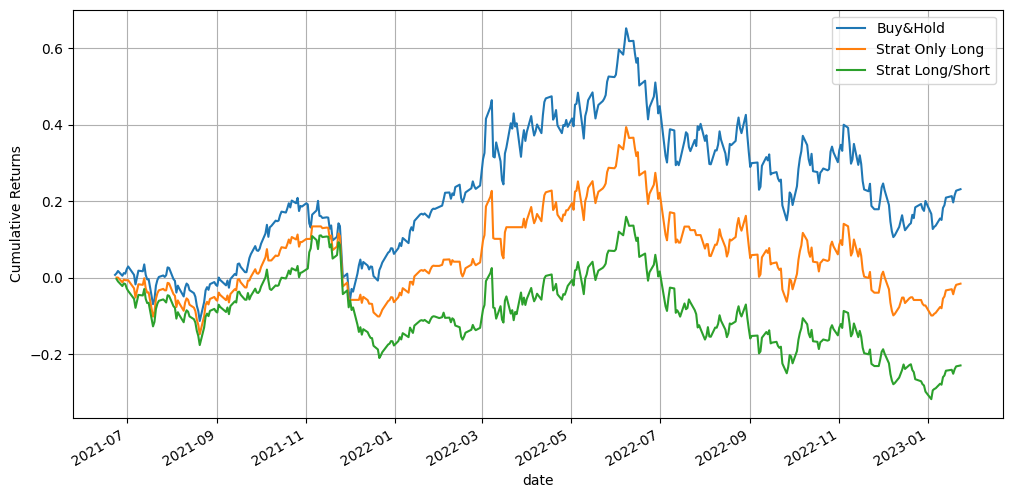

In [207]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.38      0.11      0.17       177
         1.0       0.55      0.85      0.67       222

    accuracy                           0.52       399
   macro avg       0.46      0.48      0.42       399
weighted avg       0.47      0.52      0.45       399



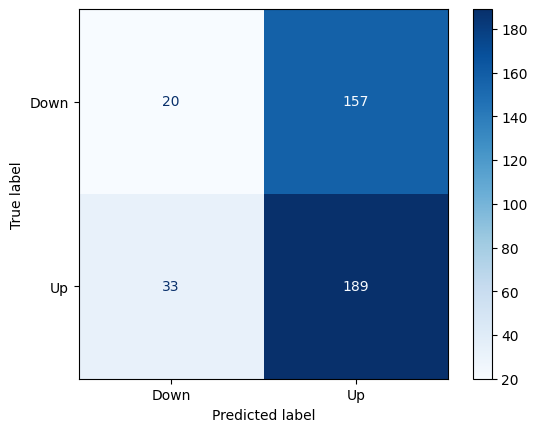

In [208]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

## non-anchored walk forward method with a train/test split 500/100

### MLP

In [209]:
n_train = 500
n_test = 100
padding = 0
window_size = 30

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Ret'], 'label', window_size=window_size, test_size=test_size, verbose=True, leakage_band=padding)

    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_MLP(window_size)
    train_model(model, X_train, y_train, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, 'label': label_backtest}
)

window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2015-04-15 00:00:00~2017-04-06 00:00:00, Test: 2017-04-07 00:00:00~2017-08-29 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 27
window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2015-09-04 00:00:00~2017-08-29 00:00:00, Test: 2017-08-30 00:00:00~2018-01-23 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 12
window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2016-01-29 00:00:00~2018-01-23 00:00:00, Test: 2018-01-24 00:00:00~2018-06-15 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 10
window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2016-06-22 00:00:00~2018-06-15 00:00:00, Test: 2018-06-18 00:00:00~2018-11-06 00:00:00
Shape of training data (500, 30, 1) (500, 1)


In [210]:
save_to_pickle(df_predictions, 'df_predictions_mlp_100_leaky.pkl')

Strat Return Long Only = 16.057731706475685 %
Strat Return = -36.866125051567366 %
Buy and Hold Return = 81.279545776673 %


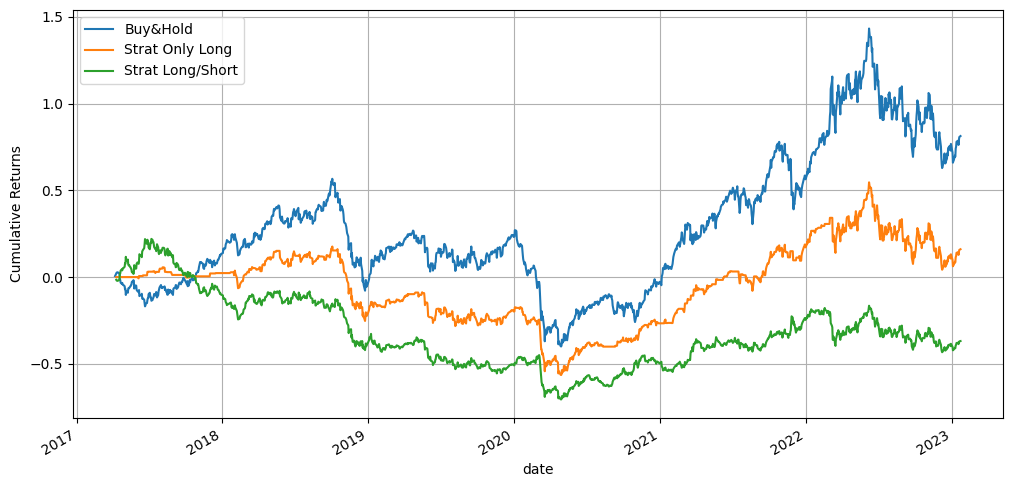

In [211]:
backtest(df_predictions)

              precision    recall  f1-score   support

         0.0       0.38      0.35      0.37       573
         1.0       0.60      0.64      0.62       885

    accuracy                           0.52      1458
   macro avg       0.49      0.49      0.49      1458
weighted avg       0.52      0.52      0.52      1458



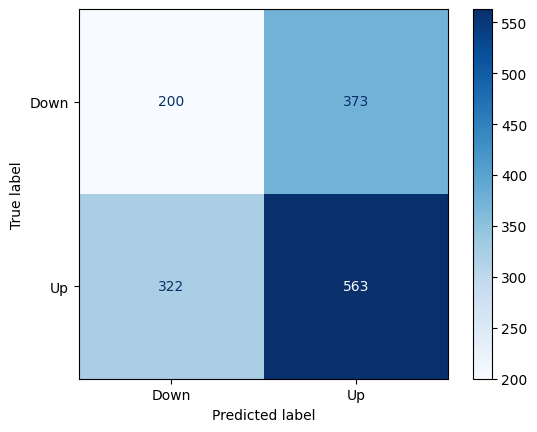

In [212]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = 12.96717066732549 %
Strat Return = 0.405763598717912 %
Buy and Hold Return = 23.11560369565777 %


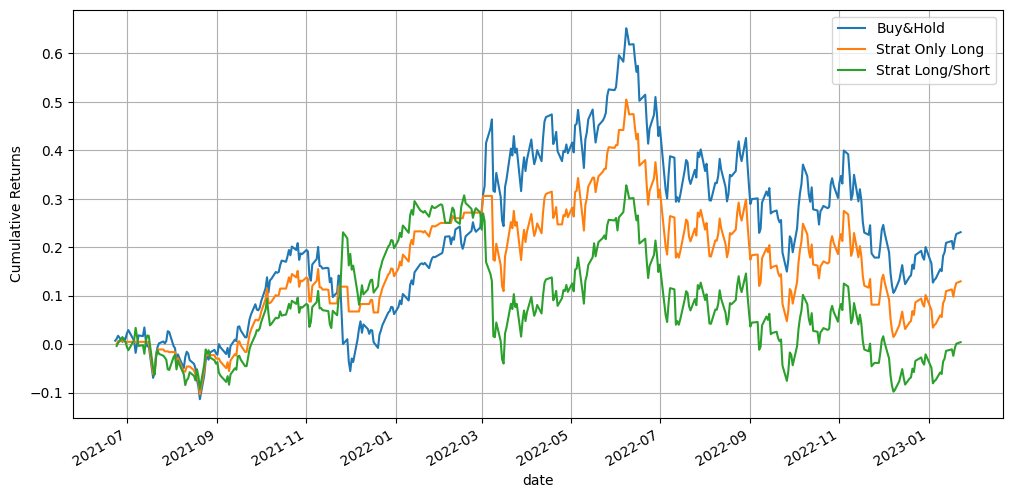

In [213]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.40      0.19      0.26       177
         1.0       0.55      0.77      0.64       222

    accuracy                           0.52       399
   macro avg       0.48      0.48      0.45       399
weighted avg       0.48      0.52      0.47       399



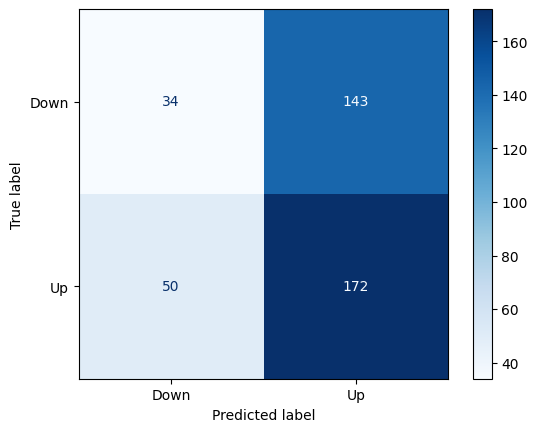

In [214]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

### LSTM

In [216]:
n_train = 500
n_test = 100
padding = 0
window_size = 30

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Ret'], 'label', window_size=window_size, test_size=test_size, verbose=True, leakage_band=padding)

    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_LSTM(window_size, 1)
    train_model(model, X_train, y_train, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2015-04-15 00:00:00~2017-04-06 00:00:00, Test: 2017-04-07 00:00:00~2017-08-29 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 22
window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2015-09-04 00:00:00~2017-08-29 00:00:00, Test: 2017-08-30 00:00:00~2018-01-23 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 10
window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2016-01-29 00:00:00~2018-01-23 00:00:00, Test: 2018-01-24 00:00:00~2018-06-15 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 10
window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2016-06-22 00:00:00~2018-06-15 00:00:00, Test: 2018-06-18 00:00:00~2018-11-06 00:00:00
Shape of training data (500, 30, 1) (500, 1)


In [217]:
save_to_pickle(df_predictions, 'df_predictions_lstm_100_leaky.pkl')

Strat Return Long Only = 16.98387976362603 %
Strat Return = -34.98495352840742 %
Buy and Hold Return = 81.279545776673 %


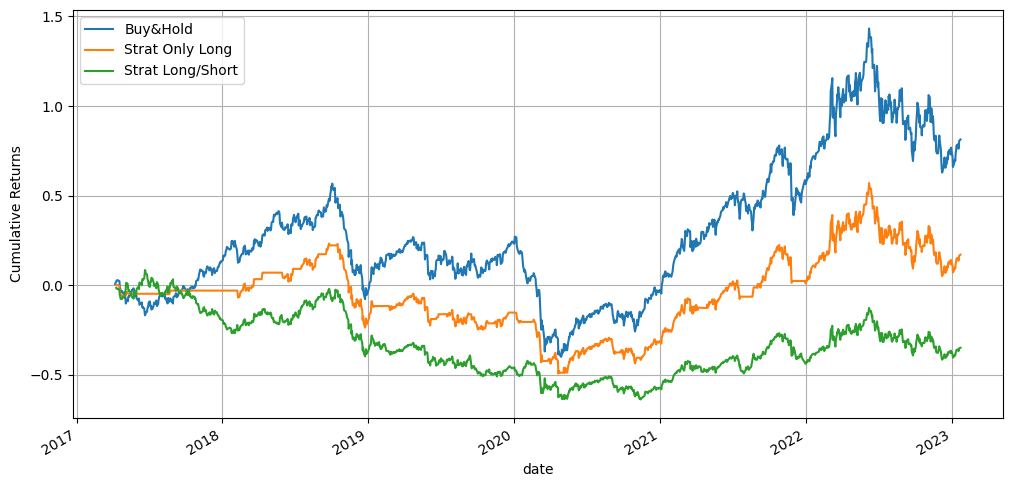

In [218]:
backtest(df_predictions)

              precision    recall  f1-score   support

         0.0       0.38      0.31      0.34       573
         1.0       0.60      0.67      0.63       885

    accuracy                           0.53      1458
   macro avg       0.49      0.49      0.49      1458
weighted avg       0.51      0.53      0.52      1458



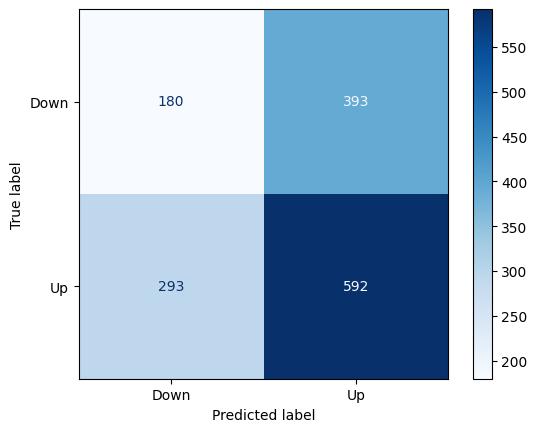

In [219]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = 17.074209917444193 %
Strat Return = 10.019260523160757 %
Buy and Hold Return = 23.11560369565777 %


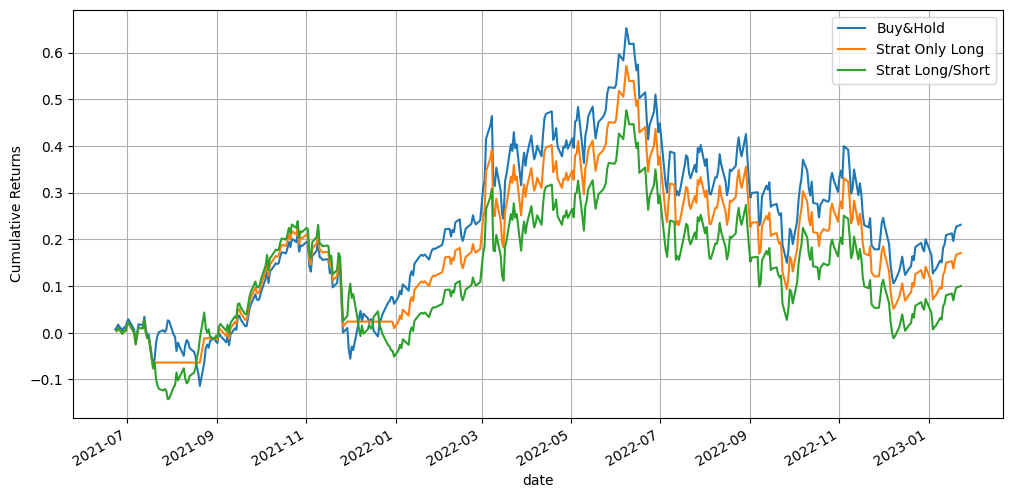

In [220]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.18      0.05      0.08       177
         1.0       0.52      0.81      0.63       222

    accuracy                           0.47       399
   macro avg       0.35      0.43      0.36       399
weighted avg       0.37      0.47      0.39       399



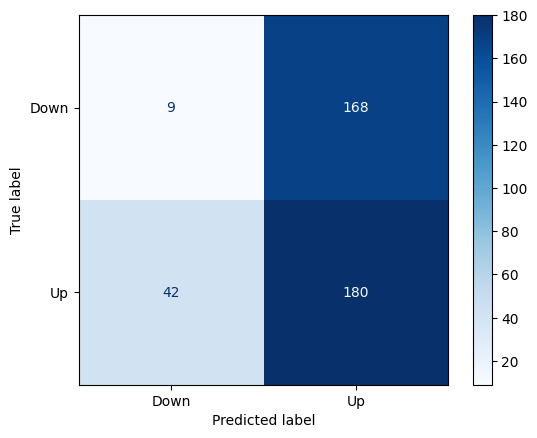

In [221]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

### CNN on GAF

In [222]:
n_train = 500
n_test = 100
padding = 0
window_size = 30

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Price'], 'label', window_size=window_size, test_size=test_size, verbose=True, input_scale=False, leakage_band=padding)

    transformer = GramianAngularField()
    X_train_gaf = transformer.transform(X_train.reshape((-1, 30)))
    X_train_gaf = X_train_gaf * 255.0
    X_test_gaf = transformer.transform(X_test.reshape((-1, 30)))
    X_test_gaf = X_test_gaf * 255.0


    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_CNN(window_size, 1)
    train_model(model, X_train_gaf, y_train, verbose=0)

    y_pred = model.predict(X_test_gaf, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2015-04-15 00:00:00~2017-04-06 00:00:00, Test: 2017-04-07 00:00:00~2017-08-29 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 31
window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2015-09-04 00:00:00~2017-08-29 00:00:00, Test: 2017-08-30 00:00:00~2018-01-23 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 20
window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2016-01-29 00:00:00~2018-01-23 00:00:00, Test: 2018-01-24 00:00:00~2018-06-15 00:00:00
Shape of training data (500, 30, 1) (500, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 11
window size:  30
Shape of dataset (530, 1) (530,) (130, 1) (130,)
Training: 2016-06-22 00:00:00~2018-06-15 00:00:00, Test: 2018-06-18 00:00:00~2018-11-06 00:00:00
Shape of training data (500, 30, 1) (500, 1)


In [223]:
save_to_pickle(df_predictions, 'df_predictions_cnn_100_leaky.pkl')

Strat Return Long Only = 34.01587378238753 %
Strat Return = -20.83591196947916 %
Buy and Hold Return = 81.279545776673 %


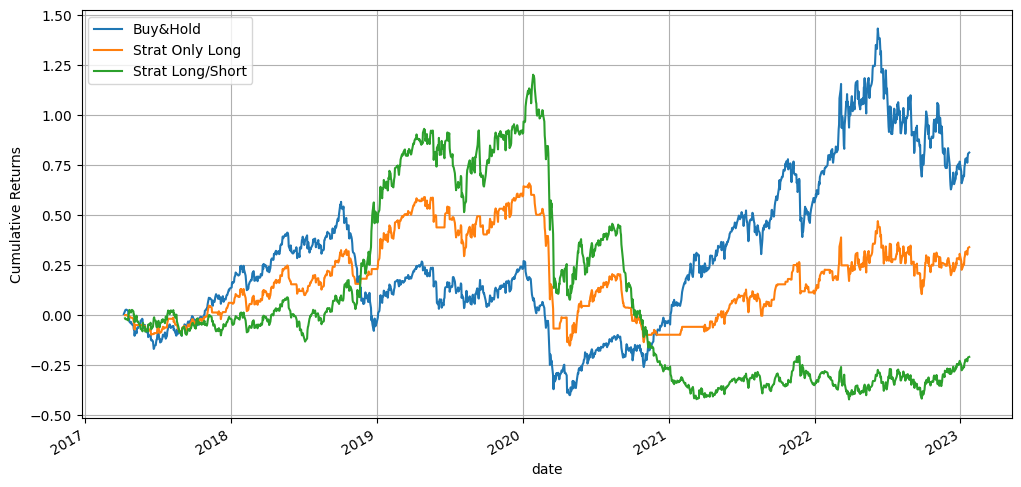

In [224]:
backtest(df_predictions)

              precision    recall  f1-score   support

         0.0       0.41      0.34      0.37       573
         1.0       0.61      0.68      0.65       885

    accuracy                           0.55      1458
   macro avg       0.51      0.51      0.51      1458
weighted avg       0.53      0.55      0.54      1458



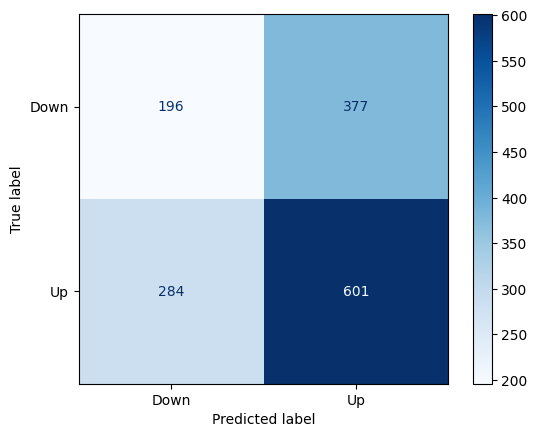

In [225]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = 22.785097440867762 %
Strat Return = 16.2491013477839 %
Buy and Hold Return = 23.11560369565777 %


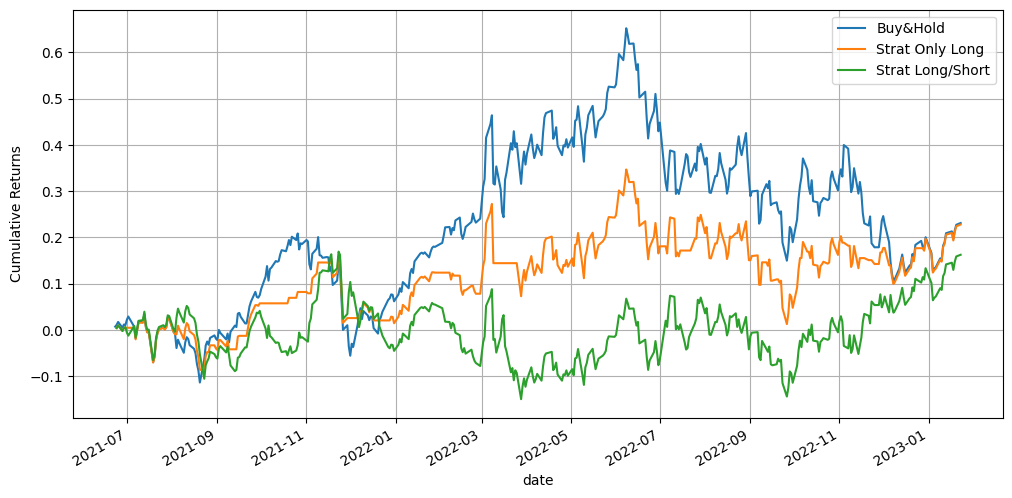

In [226]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.42      0.25      0.32       177
         1.0       0.55      0.72      0.62       222

    accuracy                           0.51       399
   macro avg       0.48      0.49      0.47       399
weighted avg       0.49      0.51      0.48       399



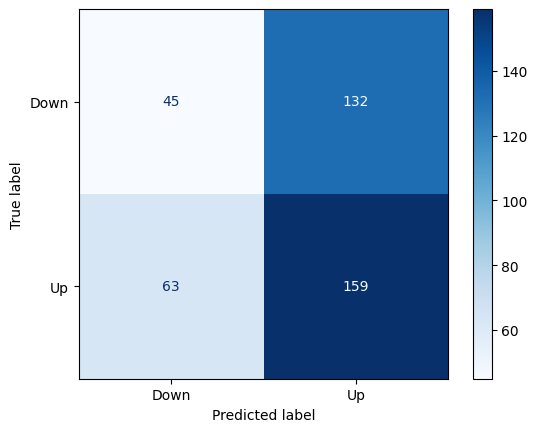

In [227]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

# Step 3

## non-anchored walk forward method with a train/test split 500/500

### MLP

In [228]:
n_train = 500
n_test = 500
window_size = 30
padding = window_size * 2

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Ret'], 'label', window_size=window_size, test_size=test_size, verbose=True, leakage_band=padding)

    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_MLP(window_size)
    train_model(model, X_train, y_train, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (470, 1) (470,) (530, 1) (530,)
Training: 2015-04-15 00:00:00~2017-01-10 00:00:00, Test: 2017-04-07 00:00:00~2019-04-03 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 10
window size:  30
Shape of dataset (470, 1) (470,) (530, 1) (530,)
Training: 2017-04-07 00:00:00~2019-01-07 00:00:00, Test: 2019-04-04 00:00:00~2021-03-29 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 10
window size:  30
Shape of dataset (470, 1) (470,) (488, 1) (488,)
Training: 2019-04-04 00:00:00~2020-12-30 00:00:00, Test: 2021-03-30 00:00:00~2023-01-23 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (458, 30, 1) (458, 1)
Best Eopch: 41


In [229]:
save_to_pickle(df_predictions, 'df_predictions_mlp_500.pkl')

Strat Return Long Only = 53.811111878378945 %
Strat Return = 9.951795976237921 %
Buy and Hold Return = 81.279545776673 %


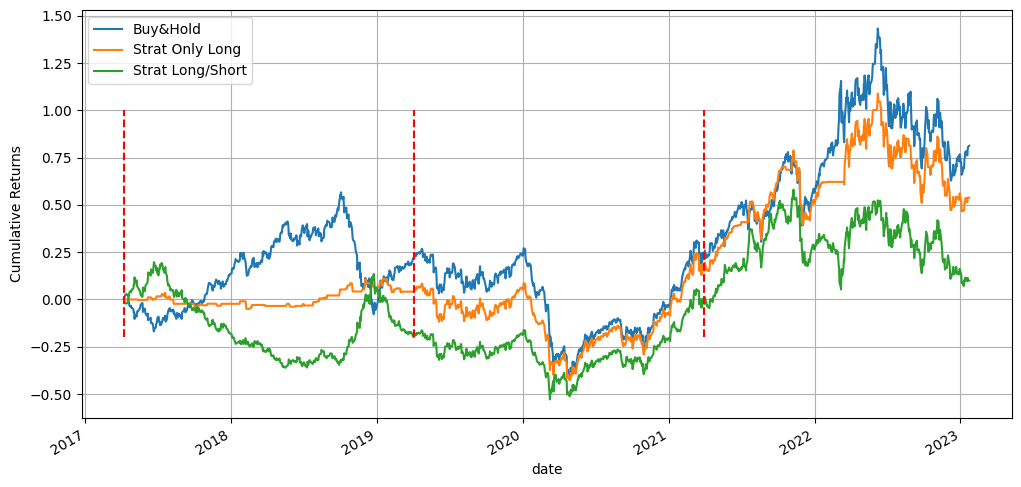

In [230]:
backtest(df_predictions, ['2017-04-07', '2019-04-04', '2021-03-30'])

              precision    recall  f1-score   support

         0.0       0.38      0.39      0.39       573
         1.0       0.60      0.58      0.59       885

    accuracy                           0.51      1458
   macro avg       0.49      0.49      0.49      1458
weighted avg       0.51      0.51      0.51      1458



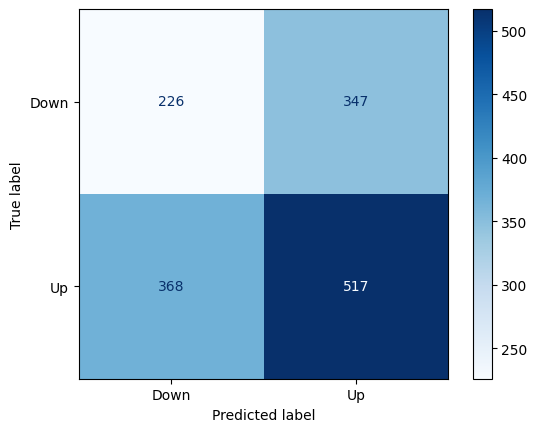

In [231]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = 10.43917028492729 %
Strat Return = -5.251541411650362 %
Buy and Hold Return = 23.11560369565777 %


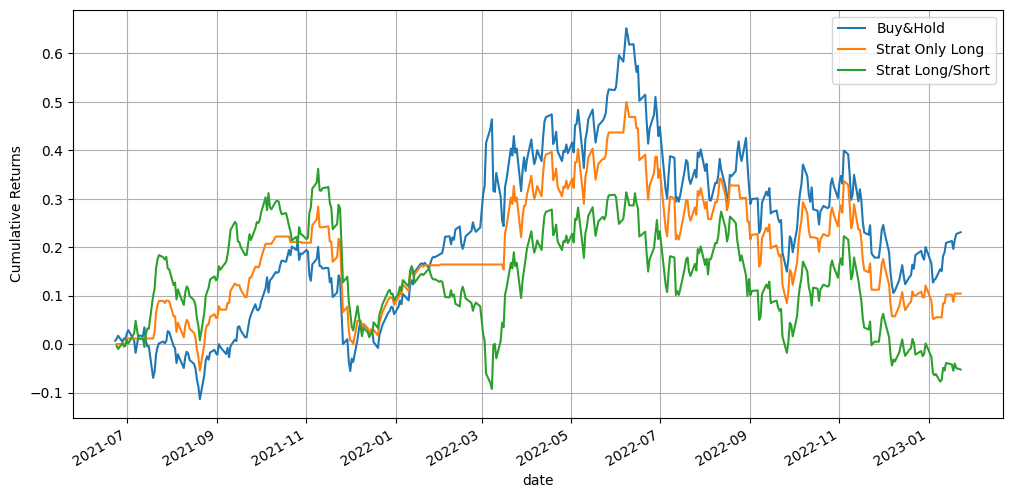

In [232]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.47      0.34      0.39       177
         1.0       0.57      0.69      0.62       222

    accuracy                           0.53       399
   macro avg       0.52      0.51      0.51       399
weighted avg       0.52      0.53      0.52       399



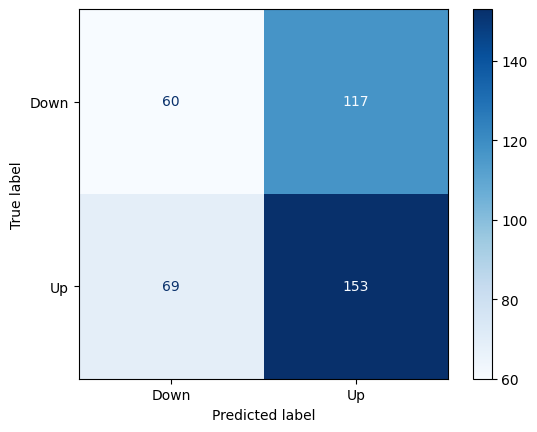

In [233]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

### LSTM

In [234]:
n_train = 500
n_test = 500
window_size = 30
padding = window_size * 2

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Ret'], 'label', window_size=window_size, test_size=test_size, verbose=True, leakage_band=padding)

    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_LSTM(window_size, 1)
    train_model(model, X_train, y_train, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (470, 1) (470,) (530, 1) (530,)
Training: 2015-04-15 00:00:00~2017-01-10 00:00:00, Test: 2017-04-07 00:00:00~2019-04-03 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 10
window size:  30
Shape of dataset (470, 1) (470,) (530, 1) (530,)
Training: 2017-04-07 00:00:00~2019-01-07 00:00:00, Test: 2019-04-04 00:00:00~2021-03-29 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 16
window size:  30
Shape of dataset (470, 1) (470,) (488, 1) (488,)
Training: 2019-04-04 00:00:00~2020-12-30 00:00:00, Test: 2021-03-30 00:00:00~2023-01-23 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (458, 30, 1) (458, 1)
Best Eopch: 32


In [235]:
save_to_pickle(df_predictions, 'df_predictions_lstm_500.pkl')

Strat Return Long Only = -23.972107671849574 %
Strat Return = -79.45383220879243 %
Buy and Hold Return = 81.279545776673 %


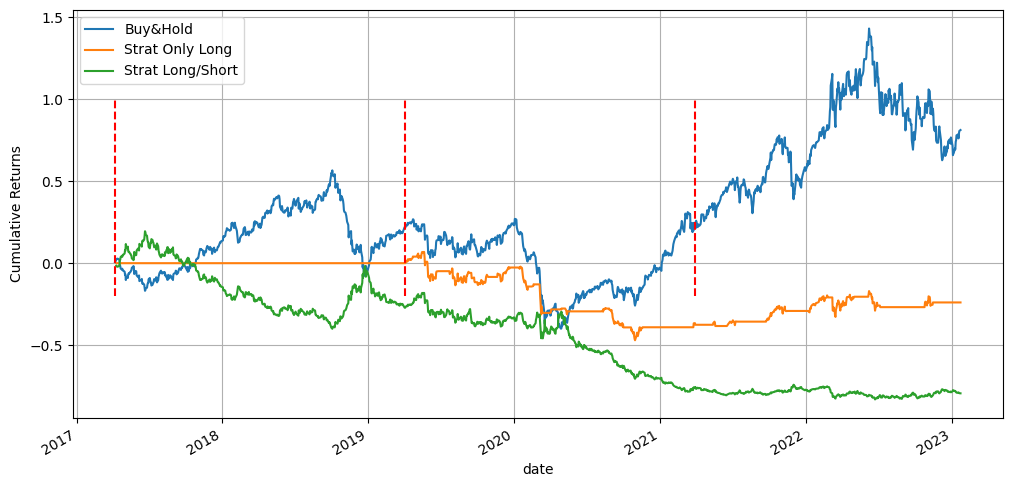

In [236]:
backtest(df_predictions, ['2017-04-07', '2019-04-04', '2021-03-30'])

              precision    recall  f1-score   support

         0.0       0.36      0.68      0.47       573
         1.0       0.51      0.21      0.30       885

    accuracy                           0.40      1458
   macro avg       0.43      0.45      0.38      1458
weighted avg       0.45      0.40      0.36      1458



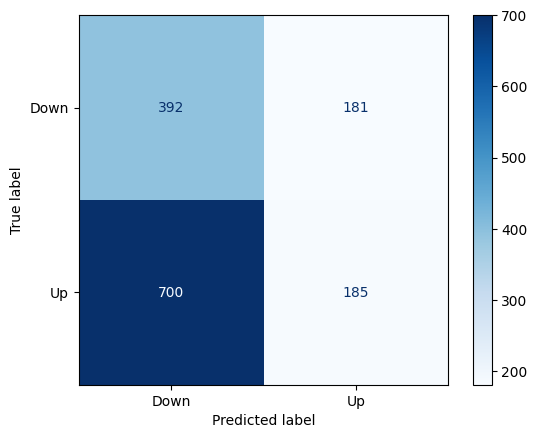

In [237]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = 19.318948682170635 %
Strat Return = 0.7503713008462976 %
Buy and Hold Return = 23.11560369565777 %


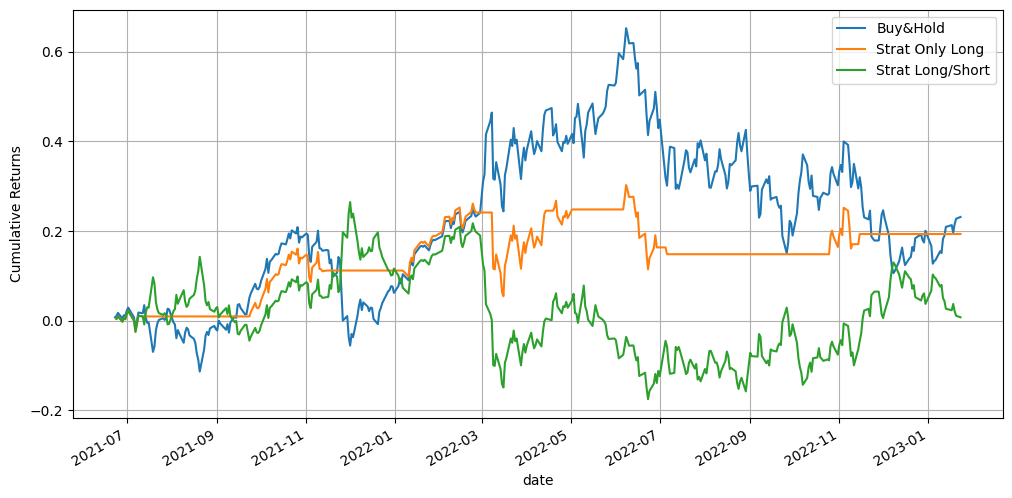

In [238]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.44      0.62      0.51       177
         1.0       0.54      0.36      0.44       222

    accuracy                           0.48       399
   macro avg       0.49      0.49      0.47       399
weighted avg       0.50      0.48      0.47       399



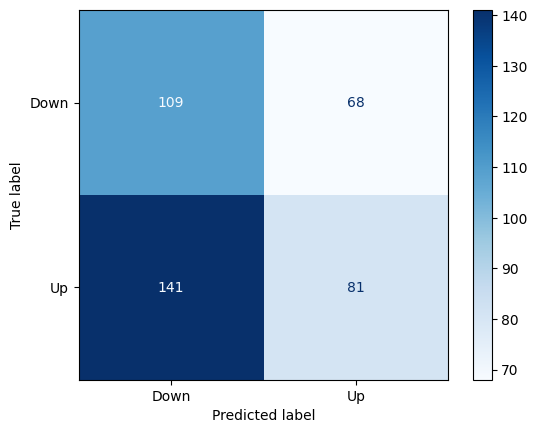

In [239]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

### CNN on GAF

In [240]:
n_train = 500
n_test = 500
window_size = 30
padding = window_size * 2

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Price'], 'label', window_size=window_size, test_size=test_size, verbose=True, input_scale=False, leakage_band=padding)

    transformer = GramianAngularField()
    X_train_gaf = transformer.transform(X_train.reshape((-1, 30)))
    X_train_gaf = X_train_gaf * 255.0
    X_test_gaf = transformer.transform(X_test.reshape((-1, 30)))
    X_test_gaf = X_test_gaf * 255.0


    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_CNN(window_size, 1)
    train_model(model, X_train_gaf, y_train, verbose=0)

    y_pred = model.predict(X_test_gaf, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (470, 1) (470,) (530, 1) (530,)
Training: 2015-04-15 00:00:00~2017-01-10 00:00:00, Test: 2017-04-07 00:00:00~2019-04-03 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 23
window size:  30
Shape of dataset (470, 1) (470,) (530, 1) (530,)
Training: 2017-04-07 00:00:00~2019-01-07 00:00:00, Test: 2019-04-04 00:00:00~2021-03-29 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (500, 30, 1) (500, 1)
Best Eopch: 11
window size:  30
Shape of dataset (470, 1) (470,) (488, 1) (488,)
Training: 2019-04-04 00:00:00~2020-12-30 00:00:00, Test: 2021-03-30 00:00:00~2023-01-23 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (458, 30, 1) (458, 1)
Best Eopch: 27


In [241]:
save_to_pickle(df_predictions, 'df_predictions_cnn_500.pkl')

Strat Return Long Only = 99.55246637504835 %
Strat Return = 54.97693835803019 %
Buy and Hold Return = 81.279545776673 %


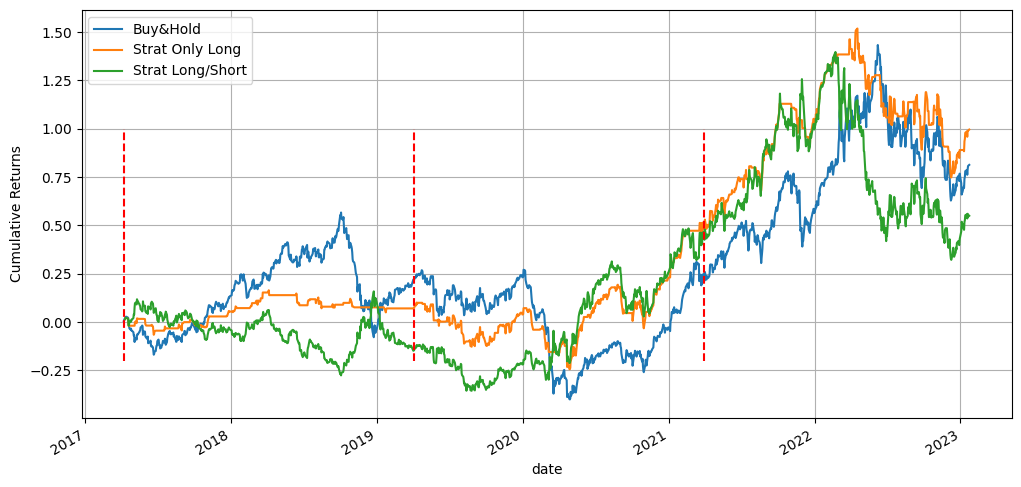

In [242]:
backtest(df_predictions, ['2017-04-07', '2019-04-04', '2021-03-30'])

              precision    recall  f1-score   support

         0.0       0.41      0.55      0.47       573
         1.0       0.63      0.49      0.55       885

    accuracy                           0.51      1458
   macro avg       0.52      0.52      0.51      1458
weighted avg       0.54      0.51      0.52      1458



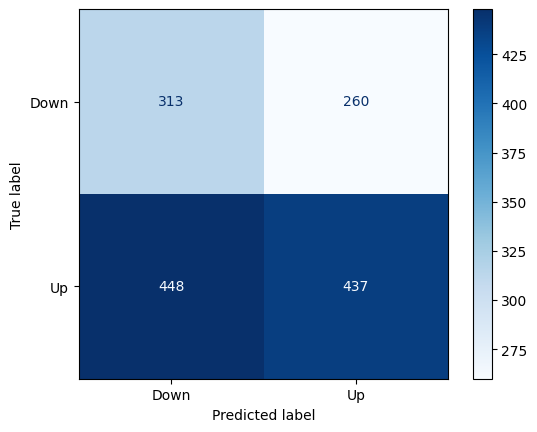

In [243]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = 14.565442055356147 %
Strat Return = -4.591046081501105 %
Buy and Hold Return = 23.11560369565777 %


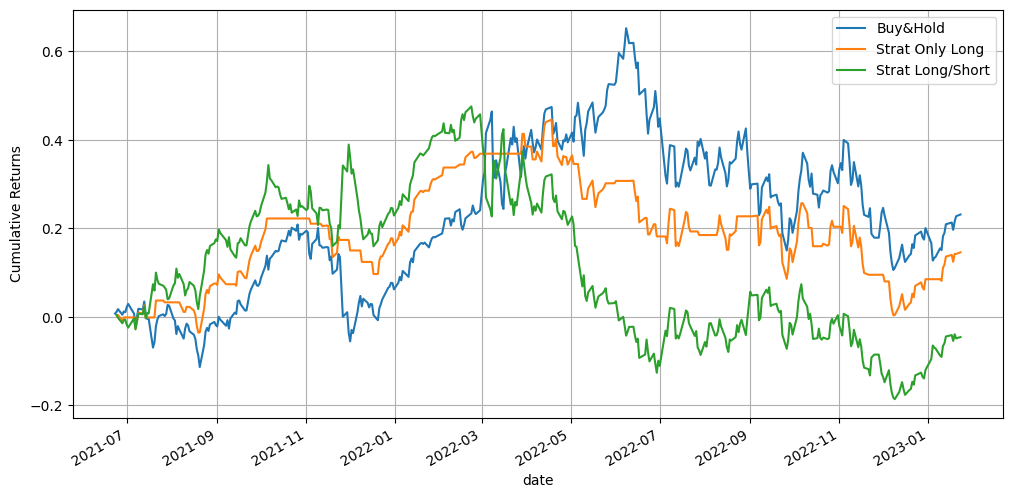

In [244]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.50      0.51      0.50       177
         1.0       0.60      0.59      0.60       222

    accuracy                           0.56       399
   macro avg       0.55      0.55      0.55       399
weighted avg       0.56      0.56      0.56       399



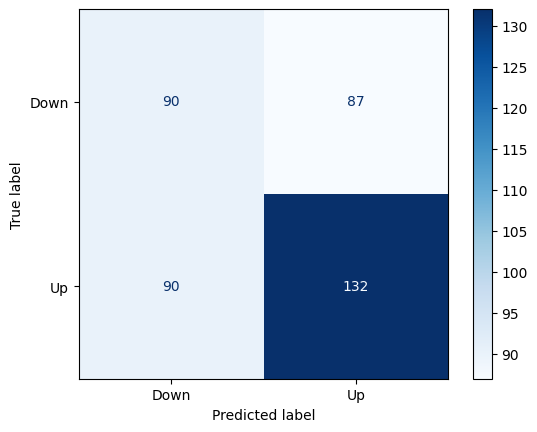

In [245]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

## non-anchored walk forward method with a train/test split 500/100

### MLP

In [246]:
n_train = 500
n_test = 100
window_size = 30
padding = window_size * 2

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Ret'], 'label', window_size=window_size, test_size=test_size, verbose=True, leakage_band=padding)

    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_MLP(window_size)
    train_model(model, X_train, y_train, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2015-04-15 00:00:00~2017-01-10 00:00:00, Test: 2017-04-07 00:00:00~2017-08-29 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 10
window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2015-09-04 00:00:00~2017-06-05 00:00:00, Test: 2017-08-30 00:00:00~2018-01-23 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 27
window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2016-01-29 00:00:00~2017-10-25 00:00:00, Test: 2018-01-24 00:00:00~2018-06-15 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 10
window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2016-06-22 00:00:00~2018-03-21 00:00:00, Test: 2018-06-18 00:00:00~2018-11-06 00:00:00
Shape of training data (440, 30, 1) (440, 1)


In [247]:
save_to_pickle(df_predictions, 'df_predictions_mlp_100.pkl')

Strat Return Long Only = 45.08894114906133 %
Strat Return = -1.0897681823201166 %
Buy and Hold Return = 81.279545776673 %


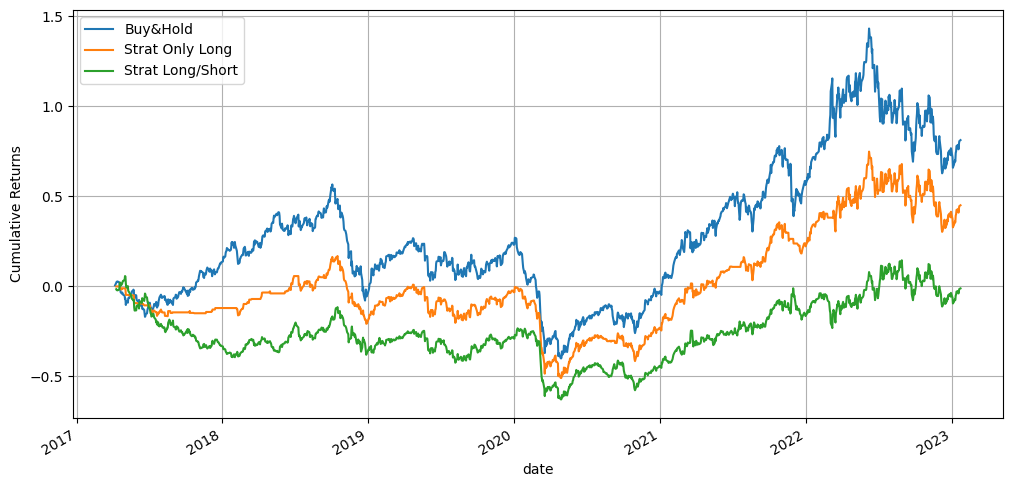

In [248]:
backtest(df_predictions)

              precision    recall  f1-score   support

         0.0       0.38      0.29      0.33       573
         1.0       0.60      0.70      0.65       885

    accuracy                           0.54      1458
   macro avg       0.49      0.49      0.49      1458
weighted avg       0.52      0.54      0.52      1458



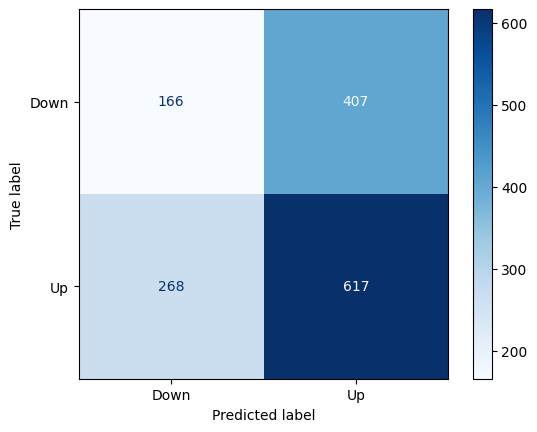

In [249]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = 31.99426687718374 %
Strat Return = 34.23641326691431 %
Buy and Hold Return = 23.11560369565777 %


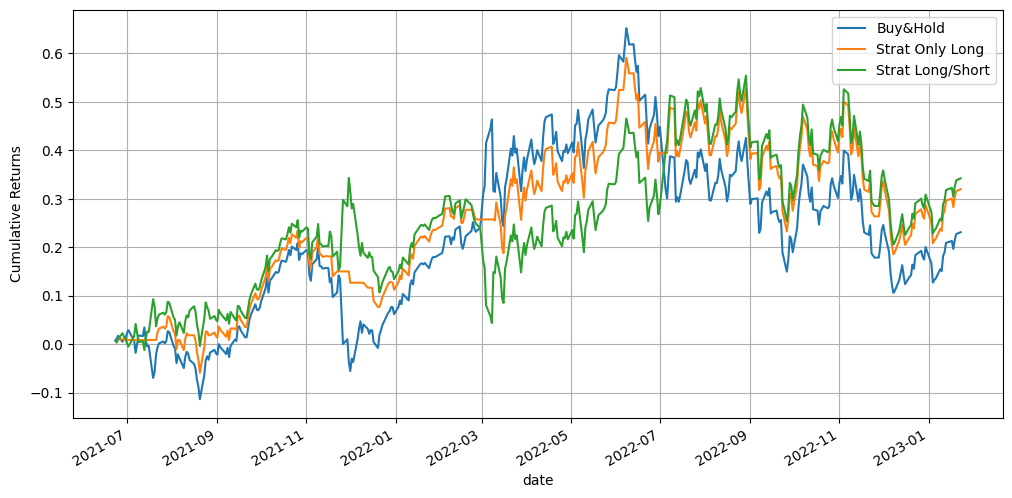

In [250]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.41      0.13      0.20       177
         1.0       0.55      0.85      0.67       222

    accuracy                           0.53       399
   macro avg       0.48      0.49      0.43       399
weighted avg       0.49      0.53      0.46       399



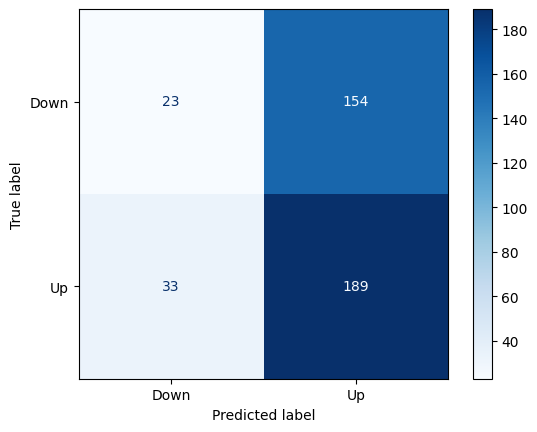

In [251]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

### LSTM

In [252]:
n_train = 500
n_test = 100
window_size = 30
padding = window_size * 2

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Ret'], 'label', window_size=window_size, test_size=test_size, verbose=True, leakage_band=padding)

    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_LSTM(window_size, 1)
    train_model(model, X_train, y_train, verbose=0)

    y_pred = model.predict(X_test, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2015-04-15 00:00:00~2017-01-10 00:00:00, Test: 2017-04-07 00:00:00~2017-08-29 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 10
window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2015-09-04 00:00:00~2017-06-05 00:00:00, Test: 2017-08-30 00:00:00~2018-01-23 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 65
window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2016-01-29 00:00:00~2017-10-25 00:00:00, Test: 2018-01-24 00:00:00~2018-06-15 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 10
window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2016-06-22 00:00:00~2018-03-21 00:00:00, Test: 2018-06-18 00:00:00~2018-11-06 00:00:00
Shape of training data (440, 30, 1) (440, 1)


In [253]:
save_to_pickle(df_predictions, 'df_predictions_lstm_100.pkl')

Strat Return Long Only = 70.9359788311393 %
Strat Return = 35.799148563123936 %
Buy and Hold Return = 81.279545776673 %


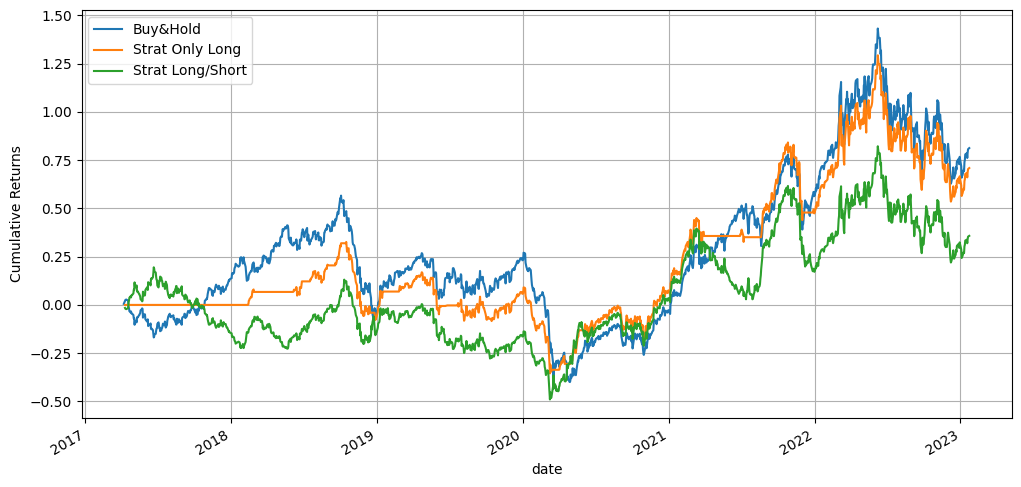

In [254]:
backtest(df_predictions)

              precision    recall  f1-score   support

         0.0       0.32      0.29      0.30       573
         1.0       0.56      0.60      0.58       885

    accuracy                           0.48      1458
   macro avg       0.44      0.44      0.44      1458
weighted avg       0.47      0.48      0.47      1458



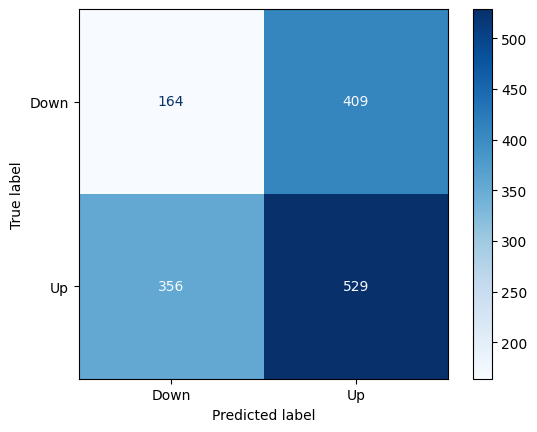

In [255]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = 25.940388731075092 %
Strat Return = 27.14168932719967 %
Buy and Hold Return = 23.11560369565777 %


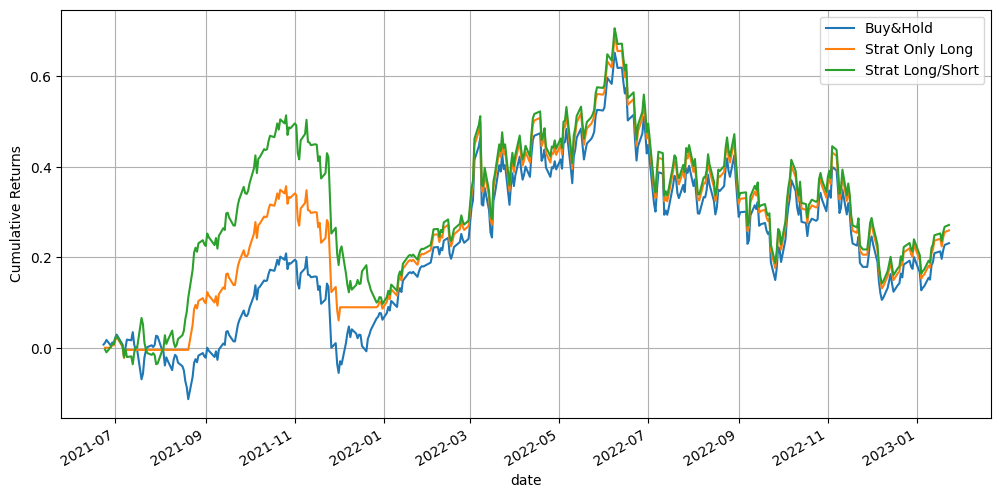

In [256]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.34      0.10      0.15       177
         1.0       0.54      0.85      0.66       222

    accuracy                           0.52       399
   macro avg       0.44      0.47      0.41       399
weighted avg       0.45      0.52      0.43       399



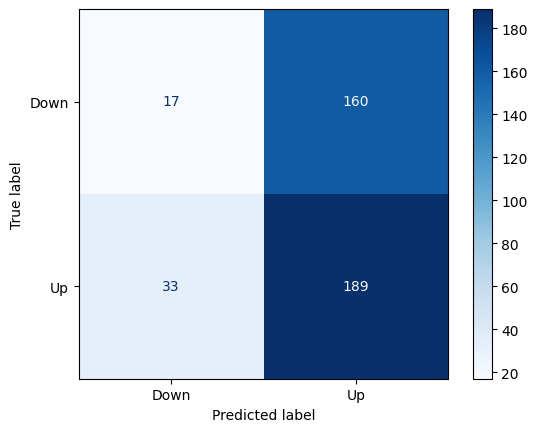

In [257]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)

### CNN on GAF

In [258]:
n_train = 500
n_test = 100
window_size = 30
padding = window_size * 2

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []
label_backtest = []

for i in range(0, dbo_data.shape[0] - n_train, n_test):
    df = dbo_data.iloc[i: i + window_size + n_train + n_test]
    test_size = df.shape[0] - window_size - n_train
    if test_size <= 0:
      break

    X_train, y_train, X_test, y_test = create_train_test(df, ['Price'], 'label', window_size=window_size, test_size=test_size, verbose=True, input_scale=False, leakage_band=padding)

    transformer = GramianAngularField()
    X_train_gaf = transformer.transform(X_train.reshape((-1, 30)))
    X_train_gaf = X_train_gaf * 255.0
    X_test_gaf = transformer.transform(X_test.reshape((-1, 30)))
    X_test_gaf = X_test_gaf * 255.0


    test_time = df.index[-test_size:]
    Ret_vector = df['Ret'][-test_size:]
    Label_vector = df['label'][-test_size:]

    model = create_CNN(window_size, 1)
    train_model(model, X_train_gaf, y_train, verbose=0)

    y_pred = model.predict(X_test_gaf, verbose=0)

    time_backtest = np.append(time_backtest, list(test_time))
    pred_backtest = np.append(pred_backtest, y_pred.flatten())
    ret_backtest = np.append(ret_backtest, list(Ret_vector))
    label_backtest = np.append(label_backtest, list(Label_vector))

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest, "label": label_backtest}
)

window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2015-04-15 00:00:00~2017-01-10 00:00:00, Test: 2017-04-07 00:00:00~2017-08-29 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 10
window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2015-09-04 00:00:00~2017-06-05 00:00:00, Test: 2017-08-30 00:00:00~2018-01-23 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 20
window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2016-01-29 00:00:00~2017-10-25 00:00:00, Test: 2018-01-24 00:00:00~2018-06-15 00:00:00
Shape of training data (440, 30, 1) (440, 1)
Shape of test data (100, 30, 1) (100, 1)
Best Eopch: 20
window size:  30
Shape of dataset (470, 1) (470,) (130, 1) (130,)
Training: 2016-06-22 00:00:00~2018-03-21 00:00:00, Test: 2018-06-18 00:00:00~2018-11-06 00:00:00
Shape of training data (440, 30, 1) (440, 1)


In [259]:
save_to_pickle(df_predictions, 'df_predictions_cnn_100.pkl')

Strat Return Long Only = 0.11394260736616868 %
Strat Return = -53.741354685783385 %
Buy and Hold Return = 81.279545776673 %


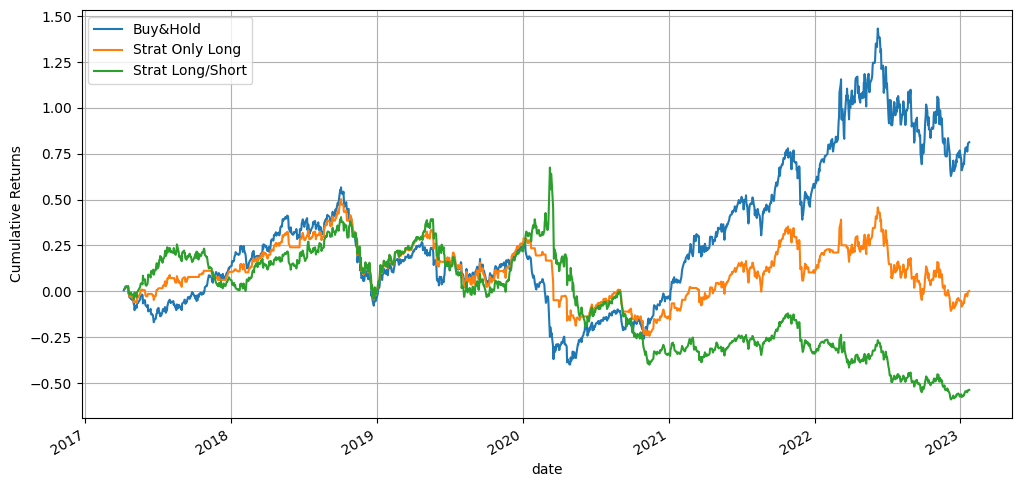

In [260]:
backtest(df_predictions)

              precision    recall  f1-score   support

         0.0       0.34      0.23      0.27       573
         1.0       0.59      0.71      0.64       885

    accuracy                           0.52      1458
   macro avg       0.46      0.47      0.46      1458
weighted avg       0.49      0.52      0.50      1458



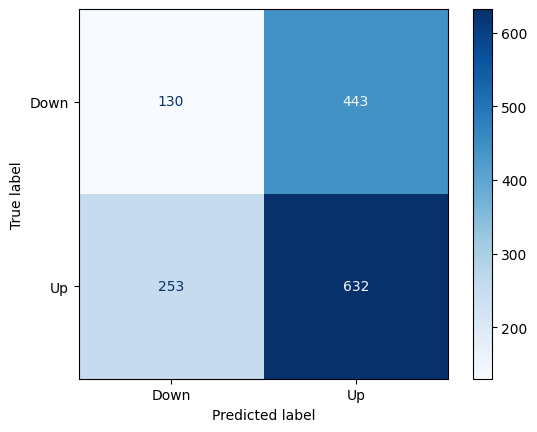

In [261]:
eval_confusion_matrix(df_predictions.label, df_predictions.Pred)

Strat Return Long Only = -12.344188833240377 %
Strat Return = -38.50572332929261 %
Buy and Hold Return = 23.11560369565777 %


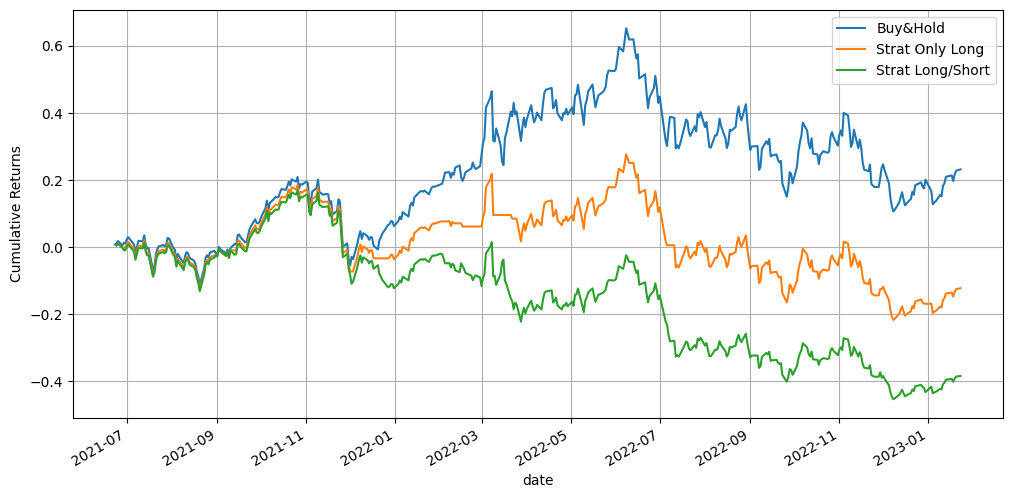

In [262]:
df_overlap = df_predictions[df_predictions.Date > '2021-06-22']
backtest(df_overlap)

              precision    recall  f1-score   support

         0.0       0.18      0.05      0.07       177
         1.0       0.52      0.84      0.64       222

    accuracy                           0.49       399
   macro avg       0.35      0.44      0.36       399
weighted avg       0.37      0.49      0.39       399



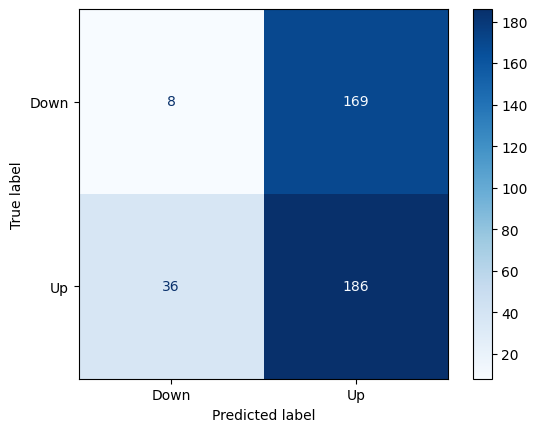

In [263]:
eval_confusion_matrix(df_overlap.label, df_overlap.Pred)